In [8]:
# pip install basemap


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import obspy
from tqdm import tqdm

from obspy.clients.fdsn import Client
from obspy.clients.fdsn import Client as FDSNClient

from mpl_toolkits.basemap import Basemap


from pnwstore.mseed import WaveformClient
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from obspy import UTCDateTime

from tqdm import tqdm
from obspy.geodetics import locations2degrees, degrees2kilometers

notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '../'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from plot_utils import *
from qc_utils import * 

## Morton Catalog

In [2]:
# Read Morton's catalog
events_morton = pd.read_csv('../data/ds01.csv')
# Convert the TSTRING to datetime
events_morton['datetime'] = pd.to_datetime(events_morton['TSTRING'], format='%Y%m%d%H%M%S', utc=True)
# Get the events in the Morton catalog 
t1 = pd.Timestamp('2011-1-1 00:00:00.000000+0000', tz='UTC')
t2 = pd.Timestamp('2015-12-31 23:59:59.999999+0000', tz='UTC')

events_morton= events_morton.loc[(events_morton['datetime'] > t1) & (events_morton['datetime'] < t2) ]

events_morton.head()

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
0,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.37,47.3217,-123.2708,...,27.4,0.19,0.8,1.2,NaN,NaN,NaN,Interface,Catalog,2011-07-26 01:02:07+00:00
1,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.72,44.2888,-124.3340,...,163.8,0.06,13.1,3.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:07+00:00
2,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,8.56,44.3017,-124.3180,...,131.1,0.50,35.4,22.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:08+00:00
3,1.0,2.011073e+13,2011.0,7.0,26.0,7.0,31.0,2.17,48.2635,-124.9298,...,44.4,0.77,3.5,6.4,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 07:31:02+00:00
4,1.0,2.011073e+13,2011.0,7.0,26.0,9.0,50.0,27.63,48.3032,-124.9157,...,46.1,0.94,4.0,6.9,NaN,NaN,NaN,Upper Plate,T,2011-07-26 09:50:27+00:00


In [3]:
events_morton

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
0,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.37,47.3217,-123.2708,...,27.4,0.19,0.8,1.2,NaN,NaN,NaN,Interface,Catalog,2011-07-26 01:02:07+00:00
1,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.72,44.2888,-124.3340,...,163.8,0.06,13.1,3.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:07+00:00
2,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,8.56,44.3017,-124.3180,...,131.1,0.50,35.4,22.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:08+00:00
3,1.0,2.011073e+13,2011.0,7.0,26.0,7.0,31.0,2.17,48.2635,-124.9298,...,44.4,0.77,3.5,6.4,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 07:31:02+00:00
4,1.0,2.011073e+13,2011.0,7.0,26.0,9.0,50.0,27.63,48.3032,-124.9157,...,46.1,0.94,4.0,6.9,NaN,NaN,NaN,Upper Plate,T,2011-07-26 09:50:27+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,4.0,2.015101e+13,2015.0,10.0,7.0,8.0,1.0,50.83,40.5895,-124.0455,...,5.4,0.14,0.9,0.8,NaN,NaN,NaN,Slab,NaN,2015-10-07 08:01:50+00:00
5278,4.0,2.015101e+13,2015.0,10.0,7.0,8.0,7.0,8.40,40.5380,-123.7217,...,14.9,0.09,3.3,13.5,NaN,NaN,NaN,Upper Plate,NaN,2015-10-07 08:07:08+00:00
5279,4.0,2.015101e+13,2015.0,10.0,7.0,11.0,31.0,26.69,40.5822,-124.0432,...,5.6,0.05,1.7,0.8,NaN,NaN,NaN,Slab,NaN,2015-10-07 11:31:26+00:00
5280,4.0,2.015101e+13,2015.0,10.0,7.0,18.0,11.0,9.52,40.2710,-124.3777,...,7.9,0.19,0.7,0.2,NaN,NaN,NaN,Upper Plate,NaN,2015-10-07 18:11:09+00:00


## ANSS Catalog

In [4]:
events_anss = pd.read_csv('../data/datasets_anss/anss_2011-15.csv')
events_anss['datetime'] = pd.to_datetime(events_anss['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
events_anss= events_anss.loc[(events_anss['datetime'] > t1) & (events_anss['datetime'] < t2) ]
events_anss

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime
0,0,2011-01-01T00:21:06.570Z,38.809834,-122.793663,1.746,0.88,md,14.0,73.0,0.001802,...,"6 km WSW of Cobb, California",earthquake,0.30,0.56,0.010,16.0,automatic,nc,nc,2011-01-01 00:21:06.570000+00:00
1,1,2011-01-01T02:04:41.480Z,38.789001,-122.747002,-0.844,0.28,md,5.0,122.0,0.009910,...,"4 km SSW of Cobb, California",earthquake,0.42,2.39,0.200,6.0,automatic,nc,nc,2011-01-01 02:04:41.480000+00:00
2,2,2011-01-01T02:53:49.640Z,38.817333,-122.821167,1.929,1.03,md,40.0,44.0,0.010810,...,"8 km W of Cobb, California",earthquake,0.14,0.19,0.060,13.0,reviewed,nc,nc,2011-01-01 02:53:49.640000+00:00
3,3,2011-01-01T03:11:04.720Z,38.841835,-122.829002,1.076,0.43,md,7.0,77.0,0.013510,...,"9 km WNW of Cobb, California",earthquake,0.43,0.88,0.150,7.0,automatic,nc,nc,2011-01-01 03:11:04.720000+00:00
4,4,2011-01-01T03:32:55.630Z,38.835833,-122.807000,0.947,0.16,md,9.0,112.0,0.012610,...,"7 km WNW of Cobb, California",earthquake,0.33,0.72,0.123,2.0,reviewed,nc,nc,2011-01-01 03:32:55.630000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131527,131527,2015-12-31T22:15:46.650Z,38.837502,-122.825333,1.450,0.18,md,6.0,180.0,0.008108,...,"9 km W of Cobb, California",earthquake,0.66,1.08,0.110,2.0,automatic,nc,nc,2015-12-31 22:15:46.650000+00:00
131528,131528,2015-12-31T22:18:13.120Z,41.856400,-119.599200,8.700,1.40,ml,6.0,210.1,0.175000,...,"45 km E of Fort Bidwell, California",earthquake,NaN,3.40,0.210,3.0,reviewed,nn,nn,2015-12-31 22:18:13.120000+00:00
131529,131529,2015-12-31T23:19:21.650Z,38.823334,-122.765663,1.680,0.54,md,7.0,99.0,0.008108,...,"3 km W of Cobb, California",earthquake,0.50,1.54,0.030,2.0,automatic,nc,nc,2015-12-31 23:19:21.650000+00:00
131530,131530,2015-12-31T23:22:20.730Z,38.841000,-122.878166,1.730,0.77,md,8.0,95.0,0.007207,...,"12 km ENE of Cloverdale, California",earthquake,0.58,1.02,0.180,3.0,automatic,nc,nc,2015-12-31 23:22:20.730000+00:00


In [43]:
print("min(events_anss['latitude']):", min(events_anss['latitude']))
print("max(events_anss['latitude']):", max(events_anss['latitude']))
print("min(events_anss['longitude']):", min(events_anss['longitude']))
print("max(events_anss['longitude']):", max(events_anss['longitude']))

min(events_anss['latitude']): 38.0001667
max(events_anss['latitude']): 50.9949
min(events_anss['longitude']): -131.1226
max(events_anss['longitude']): -119.0003


## Our Catalog

In [8]:
# Load all the pick assignments 
mycatalog = pd.read_csv('../data/datasets_all_regions/Cascadia_catalog_relocated_ver_1.csv')
mycatalog = mycatalog.rename(columns={'Latitude':'latitude',' Longitude':'longitude',' Depth (km)':'depth',' Date':'date',' ID ':'idx'})
mycatalog['datetime'] = pd.to_datetime(mycatalog['date'], utc = True)
# mycatalog = mycatalog.drop_duplicates(subset=['datetime'])
# mycatalog = mycatalog.drop(columns=['station','pick_idx','time_pick','phase'])
mycatalog = mycatalog.sort_values(by='datetime').reset_index(drop=True)
mycatalog


,latitude,longitude,depth,date,Num. P,Num. S,Num. Sta,Uncertainty (km),Detection Value,idx,datetime
0,48.49100,-122.52053,2.2725,2011-01-01T04:58:02.624119Z,1,5,5,0.3670,0.87,0,2011-01-01 04:58:02.624119+00:00
1,48.66269,-121.59949,31.7170,2011-01-01T07:40:23.438785Z,5,2,5,0.8729,0.71,1,2011-01-01 07:40:23.438785+00:00
2,40.34237,-124.62410,-0.3170,2011-01-01T10:44:24.205229Z,6,5,6,0.6304,0.86,2,2011-01-01 10:44:24.205229+00:00
3,45.62140,-122.77365,1.0450,2011-01-01T14:29:09.197902Z,5,6,7,0.2498,0.87,3,2011-01-01 14:29:09.197902+00:00
4,48.66091,-123.02596,16.1780,2011-01-01T21:15:56.060256Z,3,8,8,0.3595,0.92,4,2011-01-01 21:15:56.060256+00:00
...,...,...,...,...,...,...,...,...,...,...,...
74657,41.11039,-125.23397,-5.0000,2015-12-31T15:07:15.724982Z,2,5,5,1.7597,0.81,74657,2015-12-31 15:07:15.724982+00:00
74658,40.54897,-124.32394,13.5820,2015-12-31T16:08:32.244716Z,2,4,4,0.6061,0.81,74658,2015-12-31 16:08:32.244716+00:00
74659,40.29601,-124.36021,-4.9350,2015-12-31T17:58:19.655776Z,4,2,4,0.7416,0.84,74659,2015-12-31 17:58:19.655776+00:00
74660,40.75166,-124.46210,17.1770,2015-12-31T20:09:39.873650Z,3,5,6,1.0461,0.84,74660,2015-12-31 20:09:39.873650+00:00


In [44]:
print("min(mycatalog['latitude']):", min(mycatalog['latitude']))
print("max(mycatalog['latitude']):", max(mycatalog['latitude']))
print("min(mycatalog['longitude']):", min(mycatalog['longitude']))
print("max(mycatalog['longitude']):", max(mycatalog['longitude']))

min(mycatalog['latitude']): 37.74215
max(mycatalog['latitude']): 51.2664
min(mycatalog['longitude']): -132.32187
max(mycatalog['longitude']): -118.73213


## Run this loop

In [12]:
from obspy.geodetics import locations2degrees, degrees2kilometers

# Initialize lists to store distances
distances_morton2mycatalog = []
distances_anss2mycatalog = []

# Initialize lists to store matched and unmatched events
matched_events_mycatalog2morton = []
matched_times_morton2mycatalog = []
matched_events_morton2mycatalog = []
unmatched_times_morton2mycatalog = []
unmatched_events_morton2mycatalog = []
unmatched_events_mycatalog2morton_and_anss = []
matched_events_anss2mycatalog = []
matched_events_mycatalog2anss = []
unmatched_times_anss2mycatalog = []
unmatched_events_anss2mycatalog = []
matched_times_anss2mycatalog = []

time_threshold = 10  # in seconds
dist_threshold = 25  # in kilometers

lat_morton2mycatalog = []
lon_morton2mycatalog = []

lat_anss2mycatalog = []
lon_anss2mycatalog = []

# A set to keep track of matched indices in mycatalog
matched_indices_morton = set()
matched_indices_anss = set()
count_c = 0
count_d = 0

# Loop over events in Morton's catalog
for i in range(len(events_morton)):
    t11 = events_morton.iloc[i]['datetime']
    olat = events_morton.iloc[i]['LAT']
    olon = events_morton.iloc[i]['LON']

    condition = (mycatalog['datetime'] >= t11 - pd.Timedelta(seconds=time_threshold)) & \
                (mycatalog['datetime'] <= t11 + pd.Timedelta(seconds=time_threshold)) & \
                (degrees2kilometers(locations2degrees(olat, olon, mycatalog['latitude'], mycatalog['longitude'])) <= dist_threshold)
    matched_df = mycatalog.loc[condition]

    if len(matched_df) == 1:
        print('matched idx of Morton: ', i)
        count_c += 1
        matched_times_morton2mycatalog.append(t11)
        matched_events_morton2mycatalog.append(events_morton.iloc[i])
        lat_morton2mycatalog.append(events_morton.iloc[i]['LAT'])
        lon_morton2mycatalog.append(events_morton.iloc[i]['LON'])
        matched_events_mycatalog2morton.append(matched_df)
        matched_indices_morton.update(matched_df['idx'])
        distance = degrees2kilometers(locations2degrees(olat, olon, matched_df['latitude'].values[0], matched_df['longitude'].values[0]))
        distances_morton2mycatalog.append(distance)
    elif len(matched_df) > 1:
        print('matched idx of Morton: ', i)
        count_d += 1
        diffs = abs(matched_df['datetime'] - t11)
        closest_index = diffs.idxmin()
        closest_event = matched_df.loc[[closest_index]]
        matched_times_morton2mycatalog.append(t11)
        matched_events_morton2mycatalog.append(events_morton.iloc[i])
        lat_morton2mycatalog.append(events_morton.iloc[i]['LAT'])
        lon_morton2mycatalog.append(events_morton.iloc[i]['LON'])
        matched_events_mycatalog2morton.append(closest_event)
        matched_indices_morton.update(closest_event['idx'])
        distance = degrees2kilometers(locations2degrees(olat, olon, closest_event['latitude'].values[0], closest_event['longitude'].values[0]))
        distances_morton2mycatalog.append(distance)
    else:
        unmatched_times_morton2mycatalog.append(t11)
        unmatched_events_morton2mycatalog.append(events_morton.iloc[i])

# All events in mycatalog not matched with Morton's catalog are unmatched
unmatched_indices_morton = set(mycatalog.idx) - matched_indices_morton

count_a = 0
count_b = 0

# Loop over events in ANSS catalog
for i in range(len(events_anss)):
    t11 = events_anss.iloc[i]['datetime']
    olat = events_anss.iloc[i]['latitude']
    olon = events_anss.iloc[i]['longitude']

    condition = (mycatalog['datetime'] >= t11 - pd.Timedelta(seconds=time_threshold)) & \
                (mycatalog['datetime'] <= t11 + pd.Timedelta(seconds=time_threshold)) & \
                (degrees2kilometers(locations2degrees(olat, olon, mycatalog['latitude'], mycatalog['longitude'])) <= dist_threshold)
    matched_df = mycatalog.loc[condition]

    if len(matched_df) == 1:
        print('matched idx of ANSS: ', i)
        count_a += 1
        matched_times_anss2mycatalog.append(t11)
        matched_events_anss2mycatalog.append(events_anss.iloc[i])
        lat_anss2mycatalog.append(events_anss.iloc[i]['latitude'])
        lon_anss2mycatalog.append(events_anss.iloc[i]['longitude'])
        matched_events_mycatalog2anss.append(matched_df)
        matched_indices_anss.update(matched_df['idx'])
        distance = degrees2kilometers(locations2degrees(olat, olon, matched_df['latitude'].values[0], matched_df['longitude'].values[0]))
        distances_anss2mycatalog.append(distance)
    elif len(matched_df) > 1:
        print('matched idx of ANSS: ', i)
        count_b += 1
        diffs = abs(matched_df['datetime'] - t11)
        closest_index = diffs.idxmin()
        closest_event = matched_df.loc[[closest_index]]
        matched_times_anss2mycatalog.append(t11)
        matched_events_anss2mycatalog.append(events_anss.iloc[i])
        lat_anss2mycatalog.append(events_anss.iloc[i]['latitude'])
        lon_anss2mycatalog.append(events_anss.iloc[i]['longitude'])
        matched_events_mycatalog2anss.append(closest_event)
        matched_indices_anss.update(closest_event['idx'])
        distance = degrees2kilometers(locations2degrees(olat, olon, closest_event['latitude'].values[0], closest_event['longitude'].values[0]))
        distances_anss2mycatalog.append(distance)
    else:
        unmatched_times_anss2mycatalog.append(t11)
        unmatched_events_anss2mycatalog.append(events_anss.iloc[i])

# All events in mycatalog not matched with ANSS catalog are unmatched
unmatched_indices_anss = set(mycatalog.idx) - matched_indices_anss

unmatched_indices_morton_and_anss = unmatched_indices_morton.intersection(unmatched_indices_anss)
print(len(mycatalog), len(unmatched_indices_morton_and_anss))

unmatched_events_mycatalog2morton_and_anss = mycatalog.loc[mycatalog['idx'].isin(list(unmatched_indices_morton_and_anss))]

print(f"length of mycatalog: {len(mycatalog)}")
print(f"length of events_morton: {len(events_morton)}")
print(f"length of events_anss: {len(events_anss)}")
print(f"matched_indices_morton: {len(matched_indices_morton)}")
print(f"matched_indices_anss: {len(matched_indices_anss)}")
print(f"unmatched_indices_morton: {len(unmatched_indices_morton)}")
print(f"unmatched_indices_anss: {len(unmatched_indices_anss)}")
print(f"unmatched_indices_morton_and_anss (new events): {len(unmatched_indices_morton_and_anss)}")

matched idx of Morton:  0
matched idx of Morton:  3
matched idx of Morton:  4
matched idx of Morton:  5
matched idx of Morton:  9
matched idx of Morton:  10
matched idx of Morton:  11
matched idx of Morton:  12
matched idx of Morton:  13
matched idx of Morton:  14
matched idx of Morton:  15
matched idx of Morton:  16
matched idx of Morton:  19
matched idx of Morton:  20
matched idx of Morton:  21
matched idx of Morton:  22
matched idx of Morton:  23
matched idx of Morton:  26
matched idx of Morton:  28
matched idx of Morton:  30
matched idx of Morton:  31
matched idx of Morton:  32
matched idx of Morton:  33
matched idx of Morton:  35
matched idx of Morton:  37
matched idx of Morton:  38
matched idx of Morton:  39
matched idx of Morton:  40
matched idx of Morton:  41
matched idx of Morton:  42
matched idx of Morton:  44
matched idx of Morton:  45
matched idx of Morton:  46
matched idx of Morton:  47
matched idx of Morton:  48
matched idx of Morton:  49
matched idx of Morton:  55
matche

KeyboardInterrupt: 

In [7]:
# Concatenate and clean up dataframes
if len(matched_events_mycatalog2morton) > 0:
    matched_events_mycatalog2morton = pd.concat(matched_events_mycatalog2morton).reset_index(drop=True)
    matched_times_mycatalog2morton = matched_events_mycatalog2morton['datetime']
    lat_mycatalog2morton = matched_events_mycatalog2morton['latitude']
    lon_mycatalog2morton = matched_events_mycatalog2morton['longitude']
    # Append distances column
    matched_events_mycatalog2morton['dist_to_morton_events (km)'] = distances_morton2mycatalog

if len(matched_events_morton2mycatalog) > 0:
    matched_events_morton2mycatalog = pd.DataFrame(matched_events_morton2mycatalog).reset_index(drop=True)

if len(unmatched_events_anss2mycatalog) > 0:
    unmatched_events_anss2mycatalog = pd.DataFrame(unmatched_events_anss2mycatalog).reset_index(drop=True)

if len(unmatched_events_morton2mycatalog) > 0:
    unmatched_events_morton2mycatalog = pd.DataFrame(unmatched_events_morton2mycatalog).reset_index(drop=True)

if len(matched_events_mycatalog2anss) > 0:
    matched_events_mycatalog2anss = pd.concat(matched_events_mycatalog2anss).reset_index(drop=True)
    matched_times_mycatalog2anss = matched_events_mycatalog2anss['datetime']
    lat_mycatalog2anss = matched_events_mycatalog2anss['latitude']
    lon_mycatalog2anss = matched_events_mycatalog2anss['longitude']
    # Append distances column
    matched_events_mycatalog2anss['distance_to_anss_events (km)'] = distances_anss2mycatalog

if len(matched_events_anss2mycatalog) > 0:
    matched_events_anss2mycatalog = pd.DataFrame(matched_events_anss2mycatalog).reset_index(drop=True)
    matched_times_anss2mycatalog = matched_events_anss2mycatalog['datetime']

print(f"length of mycatalog: {len(mycatalog)}")
print(f"length of events_morton: {len(events_morton)}")
print(f"length of events_anss: {len(events_anss)}")
print(f"matched_events_mycatalog2morton: {len(matched_events_mycatalog2morton)}")
print(f"matched_events_morton2mycatalog: {len(matched_events_morton2mycatalog)}")
print(f"unmatched_events_anss2mycatalog: {len(unmatched_events_anss2mycatalog)}")
print(f"unmatched_events_morton2mycatalog: {len(unmatched_events_morton2mycatalog)}")
print(f"unmatched_events_mycatalog2morton_and_anss (new events): {len(unmatched_events_mycatalog2morton_and_anss)}")
print(f"matched_events_mycatalog2anss: {len(matched_events_mycatalog2anss)}")
print(f"matched_events_anss2mycatalog: {len(matched_events_anss2mycatalog)}")

length of mycatalog: 74662
length of events_morton: 5282
length of events_anss: 131532
matched_events_mycatalog2morton: 4282
matched_events_morton2mycatalog: 4282
unmatched_events_anss2mycatalog: 126267
unmatched_events_morton2mycatalog: 1000
unmatched_events_mycatalog2morton_and_anss (new events): 66100
matched_events_mycatalog2anss: 5265
matched_events_anss2mycatalog: 5265


In [7]:
# new concat code
# Concatenate and clean up dataframes
if len(matched_events_mycatalog2morton)>0:
    matched_events_mycatalog2morton = pd.concat(matched_events_mycatalog2morton).reset_index(drop=True)
    matched_times_mycatalog2morton = matched_events_mycatalog2morton['datetime']
    lat_mycatalog2morton = matched_events_mycatalog2morton['latitude']
    lon_mycatalog2morton = matched_events_mycatalog2morton['longitude']

if len(matched_events_morton2mycatalog)>0:   
    matched_events_morton2mycatalog = pd.DataFrame(matched_events_morton2mycatalog).reset_index(drop=True)
    
if len(unmatched_events_anss2mycatalog)>0:
    unmatched_events_anss2mycatalog = pd.DataFrame(unmatched_events_anss2mycatalog).reset_index(drop=True)
    
if len(unmatched_events_morton2mycatalog)>0:
    unmatched_events_morton2mycatalog = pd.DataFrame(unmatched_events_morton2mycatalog).reset_index(drop=True)

# if len(unmatched_events_mycatalog2morton_and_anss) > 0:
#     unmatched_events_mycatalog2morton_and_anss = unmatched_events_mycatalog2morton_and_anss.reset_index(drop=True)

if len(matched_events_mycatalog2anss)>0:
    matched_events_mycatalog2anss = pd.concat(matched_events_mycatalog2anss).reset_index(drop=True)
    matched_times_mycatalog2anss = matched_events_mycatalog2anss['datetime']
    lat_mycatalog2anss = matched_events_mycatalog2anss['latitude']
    lon_mycatalog2anss = matched_events_mycatalog2anss['longitude']

if len(matched_events_anss2mycatalog)>0:   
    matched_events_anss2mycatalog = pd.DataFrame(matched_events_anss2mycatalog).reset_index(drop=True)
    matched_times_anss2mycatalog = matched_events_anss2mycatalog['datetime']

print(f"length of mycatalog:{len(mycatalog)}")
print(f"length of events_morton:{len(events_morton)}")
print(f"length of events_anss:{len(events_anss)}")
print(f"matched_events_mycatalog2morton:{len(matched_events_mycatalog2morton)}")
print(f"matched_events_morton2mycatalog:{len(matched_events_morton2mycatalog)}")
print(f"unmatched_events_anss2mycatalog:{len(unmatched_events_anss2mycatalog)}")
print(f"unmatched_events_morton2mycatalog:{len(unmatched_events_morton2mycatalog)}")
print(f"unmatched_events_mycatalog2morton_and_anss (new events):{len(unmatched_events_mycatalog2morton_and_anss)}")
print(f"matched_events_mycatalog2anss:{len(matched_events_mycatalog2anss)}")
print(f"matched_events_anss2mycatalog:{len(matched_events_anss2mycatalog)}")

length of mycatalog:74662
length of events_morton:5282
length of events_anss:131532
matched_events_mycatalog2morton:4282
matched_events_morton2mycatalog:4282
unmatched_events_anss2mycatalog:126267
unmatched_events_morton2mycatalog:1000
unmatched_events_mycatalog2morton_and_anss (new events):66100
matched_events_mycatalog2anss:5265
matched_events_anss2mycatalog:5265


In [ ]:
new_events = pd.read_csv('../data/datasets_all_regions/new_events.csv')
new_events.rename(columns={'index': 'event_id'}, inplace=True)
new_events['event_id'] = 'uwq' + new_events.index.astype(str).str.zfill(5)



In [13]:
new_events

,Unnamed: 0,event_id,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime,event_id
0,4,3,2011-01-01 19:52:46.661153+00:00,140.013069,351.633757,8.203125,6,47.648376,-123.636385,8.203125,3,1145067,1.326894,OFR,P,1.293912e+09,2011-01-01 19:52:46.661153+00:00,uwq00000
1,13,3,2011-01-03 02:24:55.148617+00:00,90.924822,-254.856673,0.390625,6,42.200770,-124.399086,0.390625,3,281458,-0.211178,KBO,P,1.294021e+09,2011-01-03 02:24:55.148617+00:00,uwq00001
2,14,3,2011-01-03 07:08:41.304047+00:00,245.999058,-194.779791,5.859375,7,42.707510,-122.497438,5.859375,3,279799,0.646757,DBO,P,1.294039e+09,2011-01-03 07:08:41.304047+00:00,uwq00002
3,25,10,2011-01-04 11:32:14.917683+00:00,55.224278,-427.935310,0.390625,7,40.645813,-124.847109,0.390625,10,291029,0.094996,K02D,P,1.294141e+09,2011-01-04 11:32:14.917683+00:00,uwq00003
4,26,10,2011-01-04 20:15:21.450491+00:00,164.557193,438.888277,25.390625,7,48.426750,-123.276423,25.390625,10,2138533,-0.107042,LZB,S,1.294172e+09,2011-01-04 20:15:21.450491+00:00,uwq00004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52622,64413,2412,2015-12-30 07:40:58.988172+00:00,148.938205,41.236532,37.890625,8,44.855534,-123.615775,37.890625,2412,392422,-0.591419,BABR,S,1.451461e+09,2015-12-30 07:40:58.988172+00:00,uwq52622
52623,64414,2632,2015-12-30 07:41:43.690372+00:00,123.278439,-159.019742,5.859375,7,43.058776,-123.986710,5.859375,2632,445212,-0.221138,J01E,S,1.451461e+09,2015-12-30 07:41:43.690372+00:00,uwq52623
52624,64415,10951,2015-12-30 10:12:04.084015+00:00,224.801860,458.913904,9.765625,8,48.587986,-122.452629,9.765625,10951,1571010,-0.269381,CLRS,S,1.451470e+09,2015-12-30 10:12:04.084015+00:00,uwq52624
52625,64416,10952,2015-12-30 14:04:12.055910+00:00,126.625365,540.446816,5.859375,6,49.348330,-123.757253,5.859375,10952,374144,-0.009508,CLRS,P,1.451484e+09,2015-12-30 14:04:12.055910+00:00,uwq52625


In [8]:
# Save these three catalogs to csv files
year = 'all_regions'
matched_events_mycatalog2morton.to_csv(f'../data/datasets_{year}/matched_events_with_morton_mycatalog_reloc_cog.csv')
matched_events_anss2mycatalog.to_csv(f'../data/datasets_{year}/matched_events_with_mycatalog_anss_reloc_cog.csv')
matched_events_morton2mycatalog.to_csv(f'../data/datasets_{year}/matched_events_with_mycatalog_morton_reloc_cog.csv')
unmatched_events_mycatalog2morton_and_anss.to_csv(f'../data/datasets_{year}/new_events_reloc_cog.csv')
matched_events_mycatalog2anss.to_csv(f'../data/datasets_{year}/matched_events_with_anss_mycatalog_reloc_cog.csv')
unmatched_events_morton2mycatalog.to_csv(f'../data/datasets_{year}/missing_events_from_mycatalog_morton_reloc_cog.csv')
unmatched_events_anss2mycatalog.to_csv(f'../data/datasets_{year}/missing_events_from_mycatalog_anss_reloc_cog.csv')


In [16]:
year = 'all_regions'
new_events = pd.read_csv(f'../data/datasets_{year}/new_events.csv')
new_events = new_events.sort_values(by='time').reset_index(drop=True)
# Pick only the events less than 5 km deep
new_events = new_events.loc[(new_events['depth'] >= 5)&(new_events['depth'] < 10)]
new_events 

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,4,3,2011-01-01 19:52:46.661153+00:00,140.013069,351.633757,8.203125,6,47.648376,-123.636385,8.203125,3,1145067,1.326894,OFR,P,1.293912e+09,2011-01-01 19:52:46.661153+00:00
2,14,3,2011-01-03 07:08:41.304047+00:00,245.999058,-194.779791,5.859375,7,42.707510,-122.497438,5.859375,3,279799,0.646757,DBO,P,1.294039e+09,2011-01-03 07:08:41.304047+00:00
7,31,12,2011-01-05 14:35:15.536295+00:00,-290.624737,559.042042,5.078125,6,49.459134,-129.509297,5.078125,12,618680,-0.086516,W02,S,1.294238e+09,2011-01-05 14:35:15.536295+00:00
18,59,20,2011-01-10 01:38:22.198171+00:00,66.380698,-247.704663,5.078125,7,42.267618,-124.695414,5.078125,20,332582,-0.128491,K02D,P,1.294624e+09,2011-01-10 01:38:22.198171+00:00
40,140,38,2011-01-27 14:47:56.495105+00:00,-362.025824,680.626208,6.640625,6,50.509725,-130.604929,6.640625,38,597355,0.864501,W02,S,1.296140e+09,2011-01-27 14:47:56.495105+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52563,64326,10873,2015-12-08 03:09:32.946385+00:00,118.815871,441.749081,5.859375,9,48.462749,-123.893390,5.859375,10873,906783,-0.093771,CLRS,P,1.449544e+09,2015-12-08 03:09:32.946385+00:00
52612,64388,10936,2015-12-24 06:07:01.847956+00:00,123.278439,443.179483,5.078125,12,48.474749,-123.832652,5.078125,10936,1832411,0.218371,LRIV,S,1.450937e+09,2015-12-24 06:07:01.847956+00:00
52623,64414,2632,2015-12-30 07:41:43.690372+00:00,123.278439,-159.019742,5.859375,7,43.058776,-123.986710,5.859375,2632,445212,-0.221138,J01E,S,1.451461e+09,2015-12-30 07:41:43.690372+00:00
52624,64415,10951,2015-12-30 10:12:04.084015+00:00,224.801860,458.913904,9.765625,8,48.587986,-122.452629,9.765625,10951,1571010,-0.269381,CLRS,S,1.451470e+09,2015-12-30 10:12:04.084015+00:00


In [17]:
new_events.drop_duplicates(subset=['time'])
new_events

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,4,3,2011-01-01 19:52:46.661153+00:00,140.013069,351.633757,8.203125,6,47.648376,-123.636385,8.203125,3,1145067,1.326894,OFR,P,1.293912e+09,2011-01-01 19:52:46.661153+00:00
2,14,3,2011-01-03 07:08:41.304047+00:00,245.999058,-194.779791,5.859375,7,42.707510,-122.497438,5.859375,3,279799,0.646757,DBO,P,1.294039e+09,2011-01-03 07:08:41.304047+00:00
7,31,12,2011-01-05 14:35:15.536295+00:00,-290.624737,559.042042,5.078125,6,49.459134,-129.509297,5.078125,12,618680,-0.086516,W02,S,1.294238e+09,2011-01-05 14:35:15.536295+00:00
18,59,20,2011-01-10 01:38:22.198171+00:00,66.380698,-247.704663,5.078125,7,42.267618,-124.695414,5.078125,20,332582,-0.128491,K02D,P,1.294624e+09,2011-01-10 01:38:22.198171+00:00
40,140,38,2011-01-27 14:47:56.495105+00:00,-362.025824,680.626208,6.640625,6,50.509725,-130.604929,6.640625,38,597355,0.864501,W02,S,1.296140e+09,2011-01-27 14:47:56.495105+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52563,64326,10873,2015-12-08 03:09:32.946385+00:00,118.815871,441.749081,5.859375,9,48.462749,-123.893390,5.859375,10873,906783,-0.093771,CLRS,P,1.449544e+09,2015-12-08 03:09:32.946385+00:00
52612,64388,10936,2015-12-24 06:07:01.847956+00:00,123.278439,443.179483,5.078125,12,48.474749,-123.832652,5.078125,10936,1832411,0.218371,LRIV,S,1.450937e+09,2015-12-24 06:07:01.847956+00:00
52623,64414,2632,2015-12-30 07:41:43.690372+00:00,123.278439,-159.019742,5.859375,7,43.058776,-123.986710,5.859375,2632,445212,-0.221138,J01E,S,1.451461e+09,2015-12-30 07:41:43.690372+00:00
52624,64415,10951,2015-12-30 10:12:04.084015+00:00,224.801860,458.913904,9.765625,8,48.587986,-122.452629,9.765625,10951,1571010,-0.269381,CLRS,S,1.451470e+09,2015-12-30 10:12:04.084015+00:00


### Make histograms that show the distances between our events and events from other catalogs

In [6]:
year = 'all_regions'
matched_events_mycatalog2morton= pd.read_csv(f'../data/datasets_{year}/matched_events_with_morton_mycatalog_reloc_cog.csv')
matched_events_mycatalog2anss= pd.read_csv(f'../data/datasets_{year}/matched_events_with_anss_mycatalog_reloc_cog.csv')
matched_events_mycatalog2morton


,Unnamed: 0,latitude,longitude,depth,date,Num. P,Num. S,Num. Sta,Uncertainty (km),Detection Value,idx,datetime,dist_to_morton_events
0,0,47.31210,-123.26650,43.9925,2011-07-26T01:02:07.396802Z,15,19,21,0.3392,1.04,2445,2011-07-26 01:02:07.396802+00:00,1.115602
1,1,48.32898,-124.85640,-3.4510,2011-07-26T07:30:58.918890Z,4,6,6,0.2057,0.88,2449,2011-07-26 07:30:58.918890+00:00,9.082757
2,2,48.33387,-124.86002,-3.0100,2011-07-26T09:50:24.044056Z,9,7,10,0.1890,0.91,2453,2011-07-26 09:50:24.044056+00:00,5.346171
3,3,48.16048,-124.47598,31.1440,2011-07-27T14:44:02.490369Z,9,11,12,0.2103,0.98,2467,2011-07-27 14:44:02.490369+00:00,5.197995
4,4,48.36731,-124.59240,22.4405,2011-08-01T04:33:40.356737Z,3,6,6,0.3804,0.95,2573,2011-08-01 04:33:40.356737+00:00,3.887427
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,4277,43.12289,-126.82548,-1.8980,2015-10-06T10:06:48.255166Z,19,15,22,0.2175,0.94,73644,2015-10-06 10:06:48.255166+00:00,7.172556
4278,4278,40.46896,-124.63380,19.2925,2015-10-06T20:49:16.017683Z,9,9,10,0.9116,0.91,73651,2015-10-06 20:49:16.017683+00:00,8.255146
4279,4279,40.46803,-124.17175,17.0700,2015-10-07T06:50:23.406654Z,5,5,6,0.6095,0.91,73661,2015-10-07 06:50:23.406654+00:00,2.795878
4280,4280,48.94963,-126.06224,16.0315,2015-10-07T07:15:01.919771Z,8,9,10,0.6930,0.96,73662,2015-10-07 07:15:01.919771+00:00,12.858453


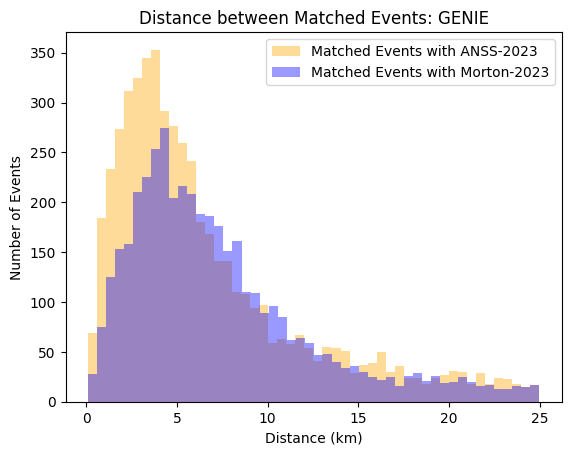

In [7]:
plt.figure()
plt.hist(matched_events_mycatalog2anss['distance_to_anss_events'],  color='orange',bins=50, alpha=0.4, label='Matched Events with ANSS-2023')
plt.hist(matched_events_mycatalog2morton['dist_to_morton_events'], color='blue',bins=50, alpha=0.4, label='Matched Events with Morton-2023')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Events')
plt.title('Distance between Matched Events: GENIE')
plt.legend()


## Plot the Origin Times

### Compare with Morton's Catalog 

In [ ]:
# Make lists for plotting the 1:1 line
x = pd.date_range(start='2011-1-1', end='2015-12-31', periods=len(matched_times_morton2mycatalog))
y = pd.date_range(start='2011-1-1', end='2015-12-31', periods=len(matched_times_morton2mycatalog))

# Plot the scatter plot
plt.figure()
plt.scatter(matched_times_mycatalog2morton,matched_times_morton2mycatalog)
plt.plot(x,y, 'k--')
plt.xlabel('Origin Time of mycatalog')
plt.ylabel('Origin Time of Morton')
plt.title('Scatter Plot: Origin Times of Matched Events')

### Compare with the ANSS Catalog 

In [ ]:
# Make lists for plotting the 1:1 line
matched_times_mycatalog2anss = pd.to_datetime(matched_times_mycatalog2anss)
matched_times_anss2mycatalog = pd.to_datetime(matched_times_anss2mycatalog)

x = pd.date_range(start='2014-1-1', end='2014-12-31', periods=len(matched_times_anss2mycatalog))
y = pd.date_range(start='2014-1-1', end='2014-12-31', periods=len(matched_times_anss2mycatalog))

# Plot the scatter plot
plt.figure()
plt.scatter(matched_times_mycatalog2anss,matched_times_anss2mycatalog)
plt.plot(x,y, 'k--')
plt.xlabel('Origin Time of mycatalog')
plt.ylabel('Origin Time of Morton')
plt.title('Scatter Plot: Origin Times of Matched Events')

## Plot the Latitudes

### Compare with Morton's Catalog 

In [ ]:
# Plot the scatter plot
plt.figure()
lat_min = min(lat_mycatalog2morton)
lat_max = max(lat_mycatalog2morton)

# Make lists for plotting the 1:1 line
x_lat = np.linspace(lat_min, lat_max, 10)
y_lat = np.linspace(lat_min, lat_max, 10)
plt.scatter(lat_mycatalog2morton,lat_morton2mycatalog, s=15)
plt.plot(x_lat,y_lat, 'k--')
plt.xlabel('Latitudes of Our Catalog ($^\circ$)')
plt.ylabel('Latitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Latitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

### Compare with the ANSS Catalog 

In [ ]:
# Plot the scatter plot
plt.figure()
lat_min = min(lat_mycatalog2anss)
lat_max = max(lat_mycatalog2anss)

# Make lists for plotting the 1:1 line
x_lat = np.linspace(lat_min, lat_max, 10)
y_lat = np.linspace(lat_min, lat_max, 10)
plt.scatter(lat_mycatalog2anss,lat_anss2mycatalog, s=15)
plt.plot(x_lat,y_lat, 'k--')
plt.xlabel('Latitudes of Our Catalog ($^\circ$)')
plt.ylabel('Latitudes of ANSS Catalog ($^\circ$)')
plt.title('Latitudes of Our Catalog vs. ANSS Catalog')

## Plot the Longitudes

### Compare with Morton's Catalog 

In [ ]:
# Plot the scatter plot
plt.figure()
lon_min = min(lon_mycatalog2morton)
lon_max = max(lon_mycatalog2morton)

# Make lists for plotting the 1:1 line
x_lon = np.linspace(lon_min, lon_max, 10)
y_lon = np.linspace(lon_min, lon_max, 10)
plt.scatter(lon_mycatalog2morton,lon_morton2mycatalog)
plt.plot(x_lon,y_lon, 'k--')
plt.xlabel('Longitudes of Our Catalog ($^\circ$)')
plt.ylabel('Longitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Longitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

### Compare with the ANSS Catalog 

In [ ]:
# Plot the scatter plot
plt.figure()
lon_min = min(lon_mycatalog2anss)
lon_max = max(lon_mycatalog2anss)

# Make lists for plotting the 1:1 line
x_lon = np.linspace(lon_min, lon_max, 10)
y_lon = np.linspace(lon_min, lon_max, 10)
plt.scatter(lon_mycatalog2anss,lon_anss2mycatalog)
plt.plot(x_lon,y_lon, 'k--')
plt.xlabel('Longitudes of Our Catalog ($^\circ$)')
plt.ylabel('Longitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Longitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

## Histograms
Make histograms of mycatalog vs. Morton's catalog

### Histogram: All of our catalog 

In [ ]:
events = pd.read_csv('../../data/datasets_all_years/events_pnsn_wa.csv')

In [ ]:
# Plot the same histogram but overlay the histograms
bins = np.linspace(5,30,25)

plt.hist(unmatched_events_mycatalog2morton_and_anss['picks'], bins=bins,  
         alpha=0.5, # the transaparency parameter 
         label='Newly detected events') 
plt.hist(matched_events_mycatalog2anss['picks'], bins=bins,
         alpha=0.5, 
         label='Events matching the ANSS Catalog')   
plt.hist(matched_events_mycatalog2morton['picks'], bins=bins,
         alpha=0.5, 
         label='Events matching Morton et al., 2023') 

plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')  
plt.legend(loc='upper right') 
plt.title('Picks vs. Number of Events') 
plt.show()


### Histogram: Matched events alone

### Compare with Morton et al. (2023)

In [ ]:
# Plot the histogram of the number of picks for the matched events
plt.figure()
bins = np.linspace(5,30,25)
plt.hist(matched_events_mycatalog2morton['picks'],bins=bins)
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')
plt.title('Histogram of Matched Events with Morton et al. (2023): Picks vs. the Number of Events')

### Compare with ANSS 

In [ ]:
# Plot the histogram of the number of picks for the matched events
plt.figure()
bins = np.linspace(5,30,25)
plt.hist(matched_events_mycatalog2anss['picks'],bins=bins)
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')
plt.title('Histogram of Matched Events with ANSS: Picks vs. the Number of Events')

## 2. Filter events 
Filter Events based on the following criteria
1. For an event, at least two stations have to be less than 50 km from the event and no station can be 100 km apart from each other.
2. An event has to have more than or equal to 6 picks


In [ ]:
# Read the new events file
events = pd.read_csv(f'../data/datasets_{year}/new_events.csv')
events

,Unnamed: 0.1,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,0,2011-01-02 02:10:45.481987+00:00,19.523735,523.281993,49.609375,10,49.206819,-125.232068,49.609375,0,358086,0.215366,W01,P,1.293934e+09,2011-01-02 02:10:45.481987+00:00
1,1,10,8,2011-01-03 22:30:53.445832+00:00,-78.652760,277.252856,12.890625,6,46.989816,-126.533950,12.890625,8,635090,-0.616663,W01,S,1.294094e+09,2011-01-03 22:30:53.445832+00:00
2,2,16,10,2011-01-05 05:25:45.145580+00:00,-97.618674,461.774708,4.296875,6,48.646430,-126.824766,4.296875,10,366668,0.805587,W04,P,1.294205e+09,2011-01-05 05:25:45.145580+00:00
3,3,22,11,2011-01-05 09:29:58.041704+00:00,-92.040464,551.890032,24.609375,7,49.457391,-126.769550,24.609375,11,581223,-0.756546,W01,S,1.294220e+09,2011-01-05 09:29:58.041704+00:00
4,4,29,12,2011-01-05 14:35:15.536295+00:00,-290.624737,559.042042,5.078125,6,49.459134,-129.509297,5.078125,12,618680,-0.086516,W02,S,1.294238e+09,2011-01-05 14:35:15.536295+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,652,186,2014-04-24 05:16:19.850574+00:00,-87.577896,616.258120,12.109375,6,50.036644,-126.722467,12.109375,186,273206,0.143698,J58C,P,1.398317e+09,2014-04-24 05:16:19.850574+00:00
71,71,664,192,2014-05-04 09:37:25.896488+00:00,-306.243725,507.547571,13.671875,6,48.989699,-129.684922,13.671875,192,192645,0.003535,J73C,P,1.399196e+09,2014-05-04 09:37:25.896488+00:00
72,72,680,201,2014-05-25 11:21:40.359990+00:00,232.611354,414.571444,49.609375,7,48.186967,-122.371453,49.609375,201,216050,0.518402,FN13C,P,1.401017e+09,2014-05-25 11:21:40.359990+00:00
73,73,687,202,2014-05-27 08:51:10.491000+00:00,-285.046527,507.547571,11.328125,8,48.999834,-129.395983,11.328125,202,284054,0.137964,J58C,P,1.401181e+09,2014-05-27 08:51:10.491000+00:00


In [ ]:
all_pick_assignments = pd.read_csv(f'../data/datasets_{year}/all_pick_assignments_{year}.csv')
mycatalog = all_pick_assignments.drop_duplicates(subset=['idx'])
mycatalog

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,0,0,2011-01-02 02:10:45.481987+00:00,19.523735,523.281993,49.609375,10,49.206819,-125.232068,49.609375,0,358086,0.215366,W01,P,1.293934e+09
10,10,8,2011-01-03 22:30:53.445832+00:00,-78.652760,277.252856,12.890625,6,46.989816,-126.533950,12.890625,8,635090,-0.616663,W01,S,1.294094e+09
16,16,10,2011-01-05 05:25:45.145580+00:00,-97.618674,461.774708,4.296875,6,48.646430,-126.824766,4.296875,10,366668,0.805587,W04,P,1.294205e+09
22,22,11,2011-01-05 09:29:58.041704+00:00,-92.040464,551.890032,24.609375,7,49.457391,-126.769550,24.609375,11,581223,-0.756546,W01,S,1.294220e+09
29,29,12,2011-01-05 14:35:15.536295+00:00,-290.624737,559.042042,5.078125,6,49.459134,-129.509297,5.078125,12,618680,-0.086516,W02,S,1.294238e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,664,192,2014-05-04 09:37:25.896488+00:00,-306.243725,507.547571,13.671875,6,48.989699,-129.684922,13.671875,192,192645,0.003535,J73C,P,1.399196e+09
670,670,199,2014-05-21 04:04:16.795543+00:00,-77.537118,533.294806,41.796875,10,49.292245,-126.565918,41.796875,199,241213,-0.340478,FN13C,P,1.400645e+09
680,680,201,2014-05-25 11:21:40.359990+00:00,232.611354,414.571444,49.609375,7,48.186967,-122.371453,49.609375,201,216050,0.518402,FN13C,P,1.401017e+09
687,687,202,2014-05-27 08:51:10.491000+00:00,-285.046527,507.547571,11.328125,8,48.999834,-129.395983,11.328125,202,284054,0.137964,J58C,P,1.401181e+09


In [ ]:
count = 0

In [ ]:
"""
Inputs:
1. Either of the following files can be the input:
    1. matched_events_with_morton_mycatalog.csv from the 4_quality_control file
    2. matched_events_with_anss_mycatalog.csv from the 4_quality_control file
    3. new_events.csv from the 4_quality_control file
2. The all_pick_assignments CSV file from the 3_associate file: e.g., all_pick_assignments = pd.read_csv('../data/datasets_2012/all_pick_assignments_2012.csv')


Outputs:
1. A new dataframe that only has events that fall into the following categories:
    1. For an event, at least two stations have to be less than 50 km from the event and no station can be 100 km apart from each other.
2. An event has to have more than or equal to 6 picks
"""

# Parameters
client2 = Client("IRIS")

mycatalog = all_pick_assignments.drop_duplicates(subset=['idx'])
mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)

for i, idx in tqdm(enumerate(events['idx']),total=len(events['idx'])):
    event = mycatalog
    picks = all_pick_assignments
    picks_idx = picks.loc[picks['idx']==idx]
    pick_sta = np.unique(picks_idx['station'])
    otime = UTCDateTime(str(event[event['idx'] == idx]["datetime"].values[0]))
    distances = []
    max_dist = 10
    min_dist = 0
    for station in pick_sta:


        sta_inv = client2.get_stations(network='*',
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e8, endtime=otime + 1e8,level="response")
        if len(sta_inv) == 0:
            print(f"Failed to fetch for {networks} {station} {otime}")
            continue

        _network = sta_inv[0].code
        slat = sta_inv[0][0].latitude
        slon = sta_inv[0][0].longitude
        olat = event.loc[event['idx']==idx, 'latitude'].values[0]
        olon = event.loc[event['idx']==idx, 'longitude'].values[0]

        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)

        distances.append([None, _network, station, dist])

    # Sort distances
    distances = sorted(distances, key=lambda item: item[-1])

    # This is for the first criterion in the markdown above
    # Determine if any two of the numbers in the distances list are less than or equal to 50
    found = False
    for i in range(len(distances)):
        for j in range(i + 1, len(distances)):
            if distances[i][3] <= 50 and distances[j][3] <= 50:
                found = True
                break
        if found:
            break

    # Make a list that includes the differences between the consecutive numbers in the distances list.
    differences = [distances[i+1][3] - distances[i][3] for i in range(len(distances) - 1)]

    if found == False: # If there were not at least two distances between the station and the event less than or equal to 50 km
        print(distances)
        index = events[events['idx'] == idx].index
        events = events.drop(index=index)

    elif any(differences > 100 for differences in differences): # If any of the distances between two stations were greater than 100 km
        print(distances)
        index = events[events['idx'] == idx].index
        events = events.drop(index=index)

    else: 
        continue


events 

/tmp/ipykernel_2189717/2718798803.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)
  1%|▏         | 1/75 [00:01<02:26,  1.98s/it]

[[None, '7A', 'W08', 111.3867302948808], [None, '7A', 'W02', 140.36804833002984], [None, '7A', 'W03', 142.5339776715801], [None, '7A', 'W04', 142.66468402551692], [None, '7A', 'W01', 149.5411371841583], [None, '3F', 'W10', 2247.0287661301577]]


  3%|▎         | 2/75 [00:03<02:13,  1.82s/it]

[[None, '7A', 'W01', 122.03878213893131], [None, '7A', 'W06', 137.2314562364737], [None, '7A', 'W07', 155.1406563393074], [None, '7A', 'W03', 156.09749788563443], [None, '7A', 'W04', 173.51166773175837]]


  4%|▍         | 3/75 [00:05<02:19,  1.93s/it]

[[None, '7A', 'W04', 13.650652436140758], [None, '7A', 'W09', 18.772825236342243], [None, '7A', 'W08', 32.455514784665795], [None, '7A', 'W07', 50.10332014067796], [None, '3F', 'W10', 2296.8799264437343]]


  5%|▌         | 4/75 [00:07<02:22,  2.01s/it]

[[None, '7A', 'W09', 86.69441189225415], [None, '7A', 'W04', 103.31155060273835], [None, '7A', 'W03', 119.00378470525456], [None, '7A', 'W02', 134.70738745617174], [None, '7A', 'W01', 156.3560152780475], [None, '3F', 'W10', 2349.816152509763]]


  7%|▋         | 5/75 [00:10<02:38,  2.26s/it]

[[None, '7A', 'W04', 217.07812668358656], [None, '7A', 'W09', 230.14455311244328], [None, '7A', 'W08', 247.53231600580256], [None, '7A', 'W02', 257.59143635459856], [None, '7A', 'W07', 264.82132306531156]]


  8%|▊         | 6/75 [00:11<02:13,  1.93s/it]

[[None, '7A', 'W04', 201.31348922576663], [None, '7A', 'W09', 220.40195413689892], [None, '7A', 'W08', 235.59153526110725]]


  9%|▉         | 7/75 [00:13<02:12,  1.95s/it]

[[None, '7A', 'W04', 98.76922465724815], [None, '7A', 'W09', 108.67114329911371], [None, '7A', 'W03', 118.3615732395473], [None, '7A', 'W08', 126.46703044365695], [None, '7A', 'W02', 140.63099035235615], [None, '7A', 'W01', 162.7128390122801]]


 11%|█         | 8/75 [00:15<02:12,  1.98s/it]

[[None, '7A', 'W04', 50.557791733052], [None, '7A', 'W08', 54.32561189689751], [None, '7A', 'W03', 66.16889506315593], [None, '7A', 'W07', 76.99274631231032], [None, '7A', 'W02', 83.08358558969938], [None, '3F', 'W10', 2317.6527667196606]]


 12%|█▏        | 9/75 [00:19<02:34,  2.34s/it]

[[None, '7A', 'W09', 28.490970009641483], [None, '7A', 'W04', 42.121498200345705], [None, '7A', 'W08', 47.145310771016256], [None, '7A', 'W03', 57.60041705239207], [None, '7A', 'W07', 69.53758047351822], [None, '3F', 'W10', 2312.2264883163084]]


 13%|█▎        | 10/75 [00:23<03:06,  2.87s/it]

[[None, '7A', 'W09', 35.63488261529117], [None, '7A', 'W04', 50.7550026906237], [None, '7A', 'W08', 53.7676377016454], [None, '7A', 'W03', 66.12364032713585], [None, '7A', 'W07', 76.47612464988256], [None, '7A', 'W02', 82.82045955215044], [None, '7A', 'W01', 105.15428144582127], [None, '3F', 'W10', 2316.792395615882]]


 15%|█▍        | 11/75 [00:25<03:00,  2.83s/it]

[[None, '7A', 'W04', 137.22963489892976], [None, '7A', 'W09', 151.87803479523126], [None, '7A', 'W03', 155.48611400050606], [None, '7A', 'W08', 168.64639056930773], [None, '7A', 'W02', 177.55173084247662], [None, '7A', 'W01', 198.1623362072592], [None, '3F', 'W10', 2428.3550505389794]]


 17%|█▋        | 13/75 [00:28<02:12,  2.14s/it]

[[None, '7A', 'W04', 189.8442039504879], [None, '7A', 'W03', 205.84758116477497], [None, '7A', 'W02', 226.74791077844574], [None, '7A', 'W01', 244.90121137805218], [None, '3F', 'W10', 2469.288059007955]]


 19%|█▊        | 14/75 [00:31<02:31,  2.49s/it]

[[None, '7A', 'W04', 132.0924767134405], [None, '7A', 'W03', 148.84033031093756], [None, '7A', 'W09', 150.5617683621225], [None, '7A', 'W08', 165.89474957884366], [None, '7A', 'W02', 170.2621953165066], [None, '7A', 'W07', 180.19490755100898], [None, '7A', 'W01', 189.50635926642587], [None, '7A', 'W06', 202.96193557634345], [None, '3F', 'W10', 2417.9593646522144]]


 20%|██        | 15/75 [00:33<02:17,  2.29s/it]

[[None, '7A', 'W04', 346.70559654469156], [None, '7A', 'W09', 353.8994486880979], [None, '7A', 'W03', 366.25858982027387], [None, '7A', 'W08', 372.4751880225134], [None, '7A', 'W02', 388.5445186730937]]


 21%|██▏       | 16/75 [00:35<02:07,  2.16s/it]

[[None, '7A', 'W04', 8.852674345192293], [None, '7A', 'W03', 26.147133773102578], [None, '7A', 'W02', 46.835506779066165], [None, '7A', 'W06', 75.0148419977528], [None, '3F', 'W10', 2295.9490226152957]]


 23%|██▎       | 17/75 [00:37<02:06,  2.19s/it]

[[None, '7A', 'W03', 248.01378805903724], [None, '7A', 'W09', 254.70156910923748], [None, '7A', 'W02', 267.8716541187159], [None, '7A', 'W08', 268.8067089255942], [None, '7A', 'W07', 280.6485437828724], [None, '7A', 'W01', 284.2741483234491], [None, '3F', 'W10', 2499.3896592189317]]


 24%|██▍       | 18/75 [00:40<02:17,  2.41s/it]

[[None, '7A', 'W04', 354.5244637454064], [None, '7A', 'W09', 356.2354843342673], [None, '7A', 'W03', 374.51798328594225], [None, '7A', 'W02', 396.32729880281715], [None, 'NV', 'NCBC', 397.57361847658206], [None, '3F', 'W10', 2637.505180764557]]


 25%|██▌       | 19/75 [00:42<02:02,  2.18s/it]

[[None, '7A', 'W04', 188.73243343832604], [None, '7A', 'W08', 223.24503483549313], [None, '7A', 'W02', 225.23352990114273], [None, '7A', 'W07', 236.54729039719615], [None, '3F', 'W10', 2466.732163089426]]


 27%|██▋       | 20/75 [00:44<02:03,  2.24s/it]

[[None, '7A', 'W04', 106.9702928056356], [None, '7A', 'W09', 123.15553045550031], [None, '7A', 'W03', 124.94895331484851], [None, '7A', 'W08', 139.290843274111], [None, '7A', 'W07', 155.04855329177641], [None, '3F', 'W10', 2397.64430388664]]


 28%|██▊       | 21/75 [00:46<01:52,  2.08s/it]

[[None, '7A', 'W09', 110.88674240854074], [None, '7A', 'W07', 126.53435558481165], [None, '7A', 'W04', 139.54489822405944], [None, '7A', 'W03', 143.2736173152938], [None, '7A', 'W02', 145.38201985560863]]


 29%|██▉       | 22/75 [00:48<01:50,  2.08s/it]

[[None, '7A', 'W04', 45.79590787303319], [None, '7A', 'W09', 52.82185049357454], [None, '7A', 'W03', 65.77954073046327], [None, '7A', 'W02', 87.46193194326715], [None, '7A', 'W01', 110.27177489787307], [None, '3F', 'W10', 2336.4031694588275]]


 31%|███       | 23/75 [00:51<01:53,  2.18s/it]

[[None, '7A', 'W01', 358.20711203036996], [None, '7A', 'W03', 364.6022768417728], [None, '7A', 'W04', 370.31996914132196], [None, '7A', 'W07', 384.9013409360639], [None, '7A', 'W08', 395.07941180640097], [None, '7A', 'W09', 397.92595476389465]]


 32%|███▏      | 24/75 [00:54<02:16,  2.68s/it]

[[None, '7A', 'W06', 237.55142775195483], [None, '7A', 'W07', 248.96571664059422], [None, '7A', 'W08', 255.26970843994954], [None, '7A', 'W01', 260.46037542811985], [None, '7A', 'W02', 266.8556282236361], [None, '7A', 'W03', 281.3704614616035], [None, 'NV', 'NC89', 287.5580861433102], [None, '7A', 'W04', 291.48982260840074], [None, '3F', 'W10', 2084.6322406944446]]


 33%|███▎      | 25/75 [00:56<01:52,  2.25s/it]

[[None, '7A', 'W04', 150.81897824527525], [None, '7A', 'W09', 171.3048314929179], [None, '7A', 'W02', 186.93230401688768], [None, '7A', 'W01', 204.84735240774182]]


 35%|███▍      | 26/75 [00:58<01:47,  2.18s/it]

[[None, '7A', 'W04', 193.71155805012316], [None, '7A', 'W09', 211.45895208607664], [None, '7A', 'W02', 231.70826371596368], [None, '7A', 'W07', 241.8253731207015], [None, '7A', 'W01', 250.53531821689134], [None, '3F', 'W10', 2476.9834952014844]]


 36%|███▌      | 27/75 [01:00<01:51,  2.31s/it]

[[None, '7A', 'W04', 29.03394416314833], [None, '7A', 'W09', 31.51804182490725], [None, '7A', 'W03', 48.02263667014009], [None, '7A', 'W08', 49.14430876674722], [None, '7A', 'W02', 68.54307537411466], [None, '7A', 'W07', 68.76687931688099], [None, '7A', 'W01', 91.55569982676326], [None, '3F', 'W10', 2315.3878448201326]]


 37%|███▋      | 28/75 [01:02<01:44,  2.23s/it]

[[None, '7A', 'W04', 117.95922058310684], [None, '7A', 'W09', 120.14511921155919], [None, '7A', 'W03', 137.94482199896643], [None, '7A', 'W02', 159.5279606615806], [None, '7A', 'W01', 182.403056029057], [None, '3F', 'W10', 2405.2468559866606]]


 39%|███▊      | 29/75 [01:04<01:39,  2.16s/it]

[[None, '7A', 'W04', 148.42328551387868], [None, '7A', 'W03', 160.4609504460381], [None, '7A', 'W02', 178.90146259256983], [None, '7A', 'W07', 193.46256434862315], [None, '7A', 'W06', 211.81581912031345], [None, '3F', 'W10', 2408.5091217969766]]


 40%|████      | 30/75 [01:06<01:36,  2.14s/it]

[[None, '7A', 'W04', 152.40514539646225], [None, '7A', 'W08', 187.47086818657272], [None, '7A', 'W02', 188.08525987962452], [None, '7A', 'W07', 199.91492485447762], [None, '7A', 'W01', 205.74163978610156], [None, '3F', 'W10', 2429.752217563015]]


 41%|████▏     | 31/75 [01:08<01:27,  2.00s/it]

[[None, '7A', 'W04', 154.26484771250657], [None, '7A', 'W09', 176.1961243596002], [None, '7A', 'W07', 201.30464295679826], [None, '7A', 'W06', 221.8308799645196], [None, '3F', 'W10', 2427.316635061178]]


 43%|████▎     | 32/75 [01:10<01:29,  2.07s/it]

[[None, '7A', 'W04', 105.75674945130913], [None, 'NV', 'NC89', 119.29353302996498], [None, '7A', 'W09', 134.375747829243], [None, '3F', 'W10', 2308.0067035131383]]


 44%|████▍     | 33/75 [01:13<01:39,  2.38s/it]

[[None, '7A', 'W06', 129.86167706471417], [None, '7A', 'W01', 144.89636747368138], [None, '7A', 'W07', 154.03279569315404], [None, '7A', 'W02', 162.56294045291608], [None, '7A', 'W08', 172.68629493816817], [None, '7A', 'W03', 184.0129787528738], [None, '7A', 'W04', 201.80322779797763], [None, '3F', 'W10', 2094.424274265831]]


 47%|████▋     | 35/75 [01:17<01:27,  2.18s/it]

[[None, '7A', 'W03', 93.89192213705371], [None, '7A', 'W06', 98.2626333060072], [None, '7A', 'W07', 105.01524643087174], [None, 'NV', 'NC89', 123.63108167079048]]


 48%|████▊     | 36/75 [01:20<01:30,  2.31s/it]

[[None, '7A', 'W04', 147.2662365984304], [None, '7A', 'W03', 160.0365524722513], [None, '7A', 'W09', 171.1937307840123], [None, '7A', 'W02', 178.99541349841846], [None, '7A', 'W01', 194.55339992245914], [None, '7A', 'W06', 212.0259174458385], [None, '3F', 'W10', 2411.827461053421]]


 49%|████▉     | 37/75 [01:22<01:25,  2.24s/it]

[[None, '7A', 'W04', 78.42569614271078], [None, '7A', 'W03', 92.26104091726877], [None, '7A', 'W02', 112.45880397170194], [None, '7A', 'W08', 114.4209720753798], [None, '7A', 'W01', 130.2789376172308], [None, '3F', 'W10', 2357.43645441117]]


 51%|█████     | 38/75 [01:24<01:17,  2.09s/it]

[[None, '7A', 'W04', 66.24477659847697], [None, '7A', 'W09', 80.8211932780077], [None, '7A', 'W03', 85.279493849945], [None, '7A', 'W02', 107.56659731719972], [None, '7A', 'W07', 113.80662848028803]]


 52%|█████▏    | 39/75 [01:26<01:14,  2.07s/it]

[[None, '7A', 'W04', 113.04338664488063], [None, '7A', 'W09', 121.89910108022703], [None, '7A', 'W03', 132.71004501740893], [None, '7A', 'W08', 139.9591336957966], [None, '7A', 'W07', 158.9722572815213], [None, '7A', 'W01', 177.11593515874173]]


 53%|█████▎    | 40/75 [01:29<01:21,  2.34s/it]

[[None, '7A', 'W04', 184.3778522232385], [None, '7A', 'W03', 186.0513053010941], [None, 'NV', 'NC89', 196.0731285948215], [None, '7A', 'W01', 199.61548811269785], [None, '7A', 'W09', 213.24600570640516]]


 55%|█████▍    | 41/75 [01:29<01:00,  1.78s/it]

[[None, '7D', 'M01A', 147.41470789951632], [None, '7D', 'J73A', 181.2473516214935], [None, '7D', 'M03A', 214.28415034393348]]


 56%|█████▌    | 42/75 [01:30<00:45,  1.37s/it]

[[None, '7D', 'J73A', 22.448137184286363], [None, '7D', 'M01A', 69.4006446853306], [None, '7D', 'M03A', 106.13976182484818]]


 57%|█████▋    | 43/75 [01:30<00:35,  1.10s/it]

[[None, '7D', 'M01A', 48.463076523333214], [None, '7D', 'J73A', 93.92800905729372], [None, '7D', 'M03A', 190.68274267802178]]


 59%|█████▊    | 44/75 [01:31<00:37,  1.20s/it]

[[None, 'NV', 'NC89', 226.57058256840386], [None, '7D', 'M01A', 234.84602087924802], [None, '7D', 'J73A', 273.304609289356], [None, '7D', 'M03A', 303.5650024105264]]


 60%|██████    | 45/75 [01:32<00:29,  1.03it/s]

[[None, '7D', 'M01A', 131.92710374231393], [None, '7D', 'J73A', 163.3278751008905], [None, '7D', 'M03A', 196.01532752957723]]


 61%|██████▏   | 46/75 [01:33<00:25,  1.15it/s]

[[None, '7D', 'M01A', 135.38697501526053], [None, '7D', 'J73A', 173.91793979106436], [None, '7D', 'M03A', 215.80121251075062], [None, '7D', 'J65A', 277.98949681952126]]


 63%|██████▎   | 47/75 [01:33<00:21,  1.28it/s]

[[None, '7D', 'M01A', 127.55765624475579], [None, '7D', 'J73A', 164.37336752565992], [None, '7D', 'J65A', 267.49360442374586]]


 64%|██████▍   | 48/75 [01:34<00:18,  1.45it/s]

[[None, '7D', 'M01A', 135.92346650431844], [None, '7D', 'J73A', 165.60140534578022], [None, '7D', 'M03A', 195.13117139124583]]


 65%|██████▌   | 49/75 [01:34<00:16,  1.60it/s]

[[None, '7D', 'M01A', 112.7980673659826], [None, '7D', 'J73A', 145.7859605020109], [None, '7D', 'M03A', 184.92166411951118]]


 67%|██████▋   | 50/75 [01:34<00:14,  1.77it/s]

[[None, '7D', 'J73A', 52.9422100799437], [None, '7D', 'M01A', 72.81295479926038], [None, '7D', 'M03A', 140.8859066672401]]


 68%|██████▊   | 51/75 [01:35<00:14,  1.60it/s]

[[None, '7D', 'M01A', 70.8109599873751], [None, '7D', 'M03A', 211.3658006865059], [None, '7D', 'J65A', 252.35432696391365], [None, '7D', 'J58A', 287.3835547492968]]


 69%|██████▉   | 52/75 [01:36<00:15,  1.48it/s]

[[None, '7D', 'M01A', 152.81120257973018], [None, '7D', 'J73A', 186.80078608848905], [None, '7D', 'M03A', 219.14555037724432], [None, '7D', 'J58A', 288.98916327058356]]


 71%|███████   | 53/75 [01:37<00:15,  1.42it/s]

[[None, '7D', 'M01A', 188.51494028980827], [None, '7D', 'J73A', 226.7157538530377], [None, '7D', 'M03A', 260.8604794865771], [None, '7D', 'J58A', 329.89957281554916]]


 72%|███████▏  | 54/75 [01:39<00:22,  1.07s/it]

[[None, '7D', 'M01A', 76.53037744104975], [None, 'NV', 'NC89', 116.00550798877157], [None, '7D', 'M03A', 218.24252367065526], [None, '7D', 'J58A', 294.18703088738994]]


 73%|███████▎  | 55/75 [01:40<00:19,  1.02it/s]

[[None, '7D', 'M01A', 100.73286379951308], [None, '7D', 'J73A', 145.33343979608605], [None, '7D', 'M03A', 201.74864547973453], [None, '7D', 'J58A', 276.9084661173776]]


 75%|███████▍  | 56/75 [01:40<00:17,  1.12it/s]

[[None, '7D', 'M01A', 210.36908189748146], [None, '7D', 'J73A', 249.11351755423914], [None, '7D', 'M03A', 281.98714767805467], [None, '7D', 'J58A', 350.0705931104255]]


 76%|███████▌  | 57/75 [01:42<00:22,  1.25s/it]

[[None, '7D', 'M01A', 215.49331663992433], [None, '7D', 'J73A', 252.91043074565007], [None, 'NV', 'NCBC', 259.3651219196685], [None, '7D', 'M03A', 282.9755164620308], [None, '7D', 'J58A', 350.10988484409523]]


 77%|███████▋  | 58/75 [01:44<00:23,  1.38s/it]

[[None, '7D', 'M01A', 212.02182113605951], [None, '7D', 'J73A', 249.6966709914149], [None, 'NV', 'NCBC', 256.4313163467824], [None, '7D', 'M03A', 280.5383008201523], [None, '7D', 'J58A', 347.9978187089811]]


 79%|███████▊  | 59/75 [01:45<00:19,  1.23s/it]

[[None, '7D', 'M01A', 106.29163042540583], [None, '7D', 'J73A', 150.65324845996727], [None, '7D', 'M03A', 205.76733222630955], [None, '7D', 'J58A', 280.6909723034838]]


 80%|████████  | 60/75 [01:48<00:28,  1.90s/it]

[[None, '7D', 'M01A', 202.57747373596214], [None, 'NV', 'NC89', 213.92299318995117], [None, '7D', 'J73A', 252.76227026715256], [None, 'NV', 'NCBC', 270.38599277308447], [None, '7D', 'M03A', 308.48941024680715]]


 83%|████████▎ | 62/75 [01:50<00:18,  1.46s/it]

[[None, '7D', 'M01C', 174.25580157154604], [None, '7D', 'J73C', 210.48016942633552], [None, '7D', 'M03C', 243.05824174849067], [None, '7D', 'M02C', 261.6628855399141], [None, '7D', 'J58C', 312.2622272957183], [None, '7D', 'FN13C', 347.2624570873544]]


 84%|████████▍ | 63/75 [01:53<00:20,  1.71s/it]

[[None, 'NV', 'NC89', 238.2154097177446], [None, '7D', 'M03C', 250.74917097588855], [None, '7D', 'M01C', 280.6058066133689], [None, '7D', 'J73C', 283.7237604878512], [None, '7D', 'J58C', 287.1875484721503], [None, '7D', 'M02C', 299.9134761633282]]


 85%|████████▌ | 64/75 [01:54<00:16,  1.48s/it]

[[None, '7D', 'M01C', 162.21029771543306], [None, '7D', 'M03C', 232.28097440180463], [None, '7D', 'M02C', 249.8493838744588], [None, '7D', 'J58C', 302.2373921343928], [None, '7D', 'FN13C', 337.6375690892374]]


 87%|████████▋ | 65/75 [01:54<00:12,  1.23s/it]

[[None, '7D', 'M01C', 109.63091669706895], [None, '7D', 'J73C', 153.44805087202005], [None, '7D', 'M03C', 207.20808672074344], [None, '7D', 'J58C', 282.0283275088091]]


 88%|████████▊ | 66/75 [01:55<00:10,  1.19s/it]

[[None, '7D', 'M01C', 125.70478274708533], [None, '7D', 'M02C', 145.04275746142383], [None, '7D', 'J58C', 177.2326200205184], [None, '7D', 'M04C', 187.97000779857558], [None, '7D', 'FN13C', 212.12082373592105]]


 89%|████████▉ | 67/75 [01:56<00:08,  1.11s/it]

[[None, '7D', 'M01C', 228.74311788686566], [None, '7D', 'J73C', 271.84429891205355], [None, '7D', 'M03C', 311.22776584912833], [None, '7D', 'M02C', 327.01719957429435], [None, '7D', 'J58C', 380.8036228005865]]


 91%|█████████ | 68/75 [01:57<00:07,  1.04s/it]

[[None, '7D', 'M01C', 36.40855938770232], [None, '7D', 'J73C', 50.626393944065065], [None, '7D', 'M03C', 120.04342409113386], [None, '7D', 'J65C', 165.94552746619678], [None, '7D', 'J58C', 196.2727887550377], [None, '7D', 'FN13C', 235.6792931992154]]


 92%|█████████▏| 69/75 [01:58<00:06,  1.08s/it]

[[None, '7D', 'M01C', 109.84264663077836], [None, '7D', 'J73C', 155.98293908334682], [None, '7D', 'M03C', 213.06846762194033], [None, '7D', 'M02C', 216.31218300823383], [None, '7D', 'J58C', 288.2614269673603], [None, '7D', 'FN13C', 326.34490789243193]]


 93%|█████████▎| 70/75 [01:59<00:05,  1.06s/it]

[[None, '7D', 'M01C', 71.93670586234168], [None, '7D', 'J73C', 128.67892217561482], [None, '7D', 'M02C', 195.7438774653067], [None, '7D', 'M03C', 218.39921230018814], [None, '7D', 'J58C', 293.5443388116445]]


 95%|█████████▍| 71/75 [02:00<00:03,  1.02it/s]

[[None, '7D', 'M01C', 98.54604323031005], [None, '7D', 'J73C', 146.19416055370132], [None, '7D', 'M03C', 243.0928890041381], [None, '7D', 'J58C', 314.6393126101694]]


 96%|█████████▌| 72/75 [02:01<00:02,  1.04it/s]

[[None, '7D', 'M01C', 216.55231506433557], [None, '7D', 'J73C', 256.5511101516682], [None, '7D', 'M03C', 291.0840689152764], [None, '7D', 'M02C', 309.4225828466929]]


 97%|█████████▋| 73/75 [02:02<00:01,  1.06it/s]

[[None, '7D', 'J65C', 208.41690832246567], [None, '7D', 'M02C', 239.5068396253581], [None, '7D', 'J58C', 255.44019616939806], [None, '7D', 'FN13C', 256.2374608227719], [None, '7D', 'M03C', 279.50777191238876]]


 99%|█████████▊| 74/75 [02:03<00:00,  1.06it/s]

[[None, '7D', 'M01C', 195.46735148817262], [None, '7D', 'J73C', 235.63038025725743], [None, '7D', 'M03C', 272.3890536432829], [None, '7D', 'M02C', 289.1701382773233], [None, '7D', 'J58C', 342.01008548906225]]


100%|██████████| 75/75 [02:04<00:00,  1.66s/it]

[[None, '7D', 'M01C', 196.2434235505692], [None, '7D', 'J73C', 234.44650226756954], [None, '7D', 'M03C', 267.73417009871946], [None, '7D', 'M02C', 286.41352450156717], [None, '7D', 'J58C', 336.4274646047452]]


,Unnamed: 0.1,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
11,11,91,25,2011-01-14 14:44:39.176230+00:00,-85.346612,448.901091,9.765625,6,48.532481,-126.655619,9.765625,25,337649,1.240566,W03,P,1.295016e+09,2011-01-14 14:44:39.176230+00:00
33,33,308,94,2011-03-07 12:39:07.528308+00:00,-84.230970,427.445061,8.203125,6,48.339717,-126.636206,8.203125,94,353740,-0.234936,W01,P,1.299502e+09,2011-03-07 12:39:07.528308+00:00
60,60,519,154,2014-01-02 19:34:45.261401+00:00,-48.530426,417.432248,39.453125,6,48.253425,-126.153530,39.453125,154,465717,0.368089,FN13C,S,1.388691e+09,2014-01-02 19:34:45.261401+00:00


In [ ]:
new_events_filtered = filter_sta(new_events, mycatalog_picks)

In [ ]:
new_events_filtered.to_csv(f'../data/datasets_{year}/new_events_filtered_{year}.csv')

In [ ]:
events.to_csv(f'../data/datasets_{year}/new_events_filtered_{year}.csv')

In [ ]:
events

,Unnamed: 0.1,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,2,2011-08-09 10:26:19.327686+00:00,88.408817,254.877921,0.390625,6,46.787357,-124.342163,0.390625,2,2109680,-0.551091,FN07A,P,1.312886e+09,2011-08-09 10:26:19.327686+00:00
1,1,12,34,2011-10-16 22:22:10.456747+00:00,53.722104,262.057644,0.390625,6,46.855631,-124.795545,0.390625,34,1965245,-1.060968,FN07A,P,1.318804e+09,2011-10-16 22:22:10.456747+00:00
3,3,32,65,2011-10-22 21:20:51.997895+00:00,53.722104,259.664403,8.984375,6,46.834105,-124.795826,8.984375,65,1885860,0.724684,FN07A,P,1.319318e+09,2011-10-22 21:20:51.997895+00:00
4,4,38,84,2011-10-26 15:45:12.545541+00:00,55.414139,257.271162,12.890625,6,46.812439,-124.773939,12.890625,84,2111346,1.229328,FN07A,P,1.319644e+09,2011-10-26 15:45:12.545541+00:00
5,5,44,98,2011-10-30 16:30:50.644314+00:00,54.568121,276.417089,7.421875,6,46.984720,-124.782730,7.421875,98,1988348,1.249747,FN07A,P,1.319992e+09,2011-10-30 16:30:50.644314+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16139,16139,100086,62680,2014-06-27 07:59:17.730075+00:00,41.031843,308.725840,13.671875,6,47.276299,-124.957702,13.671875,62680,1835238,1.220912,FN09C,P,1.403856e+09,2014-06-27 07:59:17.730075+00:00
16140,16140,100092,62681,2014-06-27 08:00:36.709904+00:00,51.184052,264.450885,0.390625,6,46.877358,-124.828555,0.390625,62681,3738781,0.753338,FN03C,S,1.403856e+09,2014-06-27 08:00:36.709904+00:00
16142,16142,100104,62692,2014-06-27 09:52:36.180245+00:00,47.799982,256.074542,7.421875,6,46.802265,-124.873822,7.421875,62692,1710667,1.188087,FN03C,P,1.403863e+09,2014-06-27 09:52:36.180245+00:00
16143,16143,100110,62698,2014-06-27 12:02:50.342653+00:00,24.957513,254.877921,10.546875,6,46.792747,-125.173115,10.546875,62698,1699516,0.718257,FN08C,P,1.403871e+09,2014-06-27 12:02:50.342653+00:00


## Plot events 

### Plot new events shallower than 5 km

In [79]:
def subplots_cluster_scale(mycatalog, mycatalog_picks, networks, channel, fig_title, filepath):
    """
    mycatalog: dataframe that contains only the unique events (e.g., mycatalog_picks.drop_duplicates(subset=['idx']).copy())
    mycatalog_picks: all pick assignments csv file (e.g., pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv'))
    networks: csv file listing at least the networks of stations that picked the events in mycatalog (e.g., pd.read_csv('../data/networks/networks.csv))
    channel: specify the direction of the channel (i.e., "?HZ", "?HE" or "?HN")
    fig_title: title in a string
    filepath: path to save the pdf file
    """
        
    # Define the clients 
    client_waveform = WaveformClient()
    client2 = Client("IRIS")
    client_ncedc = Client('NCEDC')

    # Plot the earthquake moveout for one of the unmatched events for all stations 
    events = mycatalog
    picks = mycatalog_picks
    events['datetime'] = pd.to_datetime(events['time'], utc=True)
    networks = ','.join(list(networks['networks']))
    p = PdfPages(filepath) 
        

    for time in tqdm(events['time'], total=len(events['time'])):

        idx = events.loc[events['datetime'] == time, 'idx'].values[0]
        # print('idx:', idx)
        picks_idx = picks.loc[picks['time'] == time]
        pick_sta = np.unique(picks_idx['station'])

        otime = UTCDateTime(str(time))
        distances = []
         
        print('otime:',otime)

        for station in pick_sta:
            sta_inv = client2.get_stations(network=networks,
                                           station=station, channel="?H?", 
                                           starttime=otime - 1e8, endtime=otime + 1e8, level="response")
            if len(sta_inv) == 0:
                continue
            
            _network = sta_inv[0].code
            slat = sta_inv[0][0].latitude
            slon = sta_inv[0][0].longitude
            olat = events.loc[events['idx']==idx, 'latitude'].values[0]
            olon = events.loc[events['idx']==idx, 'longitude'].values[0]

            dis1 = locations2degrees(olat, olon, slat, slon)
            dist = degrees2kilometers(dis1)

            distances.append([None, _network, station, dist])

        # Sort distances
        distances = sorted(distances, key=lambda item: item[-1])
        # print(distances)
        # Set up to define the xlim and ylim
        max_y = 0
        min_y = 0
        min_y_count = 0 

        max_x = 0
        min_x = 0
        min_x_count= 0

        # Create a figure
        fig, axs = plt.subplots(1, 4, figsize=(18, 6))
        gs = fig.add_gridspec(3, hspace=0, figure=fig)
        starttime = otime - 30
        endtime = otime + 120
        # Define texts
        texts = []
        # print('starttime:', starttime)
        # print('endtime:', endtime)
        for i, ii in enumerate(distances):
            # print('Network:', ii[1])
            # print('Station:', ii[2])
            
            if ii[1] in ['NC', 'BK']:
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
            else: 
                st = Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

            if len(st) == 0:
                continue
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

            if len(s_picks) > 0:
                if max_x < UTCDateTime(s_picks.iloc[0]['time_pick']) - starttime:
                    max_x = UTCDateTime(s_picks.iloc[0]['time_pick']+5) - starttime
            elif len(p_picks) > 0:
                if max_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime: 
                    max_x = UTCDateTime(p_picks.iloc[0]['time_pick']+5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue 

            if len(p_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime
                        min_x_count += 1           
                else:
                    if min_x >= UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime            
            elif len(s_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5)- starttime
                        min_x_count += 1                
                else:
                    if min_x >= UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue    

            if min_y_count == 0:
                if min_y < ii[3]:
                    min_y = ii[3] - 5
                    min_y_count += 1           
            else:
                if min_y >= ii[3]:
                    min_y = ii[3] - 5 

            max_y = ii[3] + 5

        scaling_factor = (1/2) * (max_y - min_y)

        chs = []  # Initialize chs here
        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
            else: 
                st = Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

            if len(st) == 0:
                continue

            _st = Stream()
            has_HH = bool(st.select(channel="HH?"))
            has_BH = bool(st.select(channel="BH?"))

            if has_HH and has_BH:
                _st += st.select(channel="HH?")
            elif has_HH:
                _st += st.select(channel="HH?")
            elif has_BH:
                _st += st.select(channel="BH?")

            st = _st

            st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
            st.taper(max_percentage=0.05)
            st.filter(type='bandpass', freqmin=2, freqmax=25)
            st.merge(fill_value='interpolate')

            unique_channels = set(tr.stats.channel for tr in st)
            selected_traces = []

            for ch in unique_channels:
                selected_traces.append(next(tr for tr in st if tr.stats.channel == ch))
            st = Stream(selected_traces)

            trim_st = st.copy()
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

            # Define the desired order of channels
            desired_order = {
                'Z': ['HHZ', 'BHZ'],
                'N': ['HHN', 'HH1', 'BHN', 'BH1'],
                'E': ['HHE', 'HH2', 'BHE', 'BH2']
            }

            # Function to map channels to their desired order
            def get_channel_priority(channel):
                for priority, (key, values) in enumerate(desired_order.items()):
                    if channel in values:
                        return priority
                return float('inf')  # Return a high value for channels not in the desired order

            # Sort the traces in trim_st based on the desired order
            trim_st = sorted(trim_st, key=lambda trace: get_channel_priority(trace.stats.channel))
            
            trim_st = Stream(trim_st)
            
            print(trim_st)

            # trim_st.plot()

            # plt.figure()
            # trim_st.plot()
            # plt.show()
            for iax in range(len(trim_st)):
                sampling_rate = trim_st[iax].stats.sampling_rate
                trim_st = trim_st.normalize()

                if i == 0:
                    chs.append(str(trim_st[iax].stats.channel))
                if len(p_picks) > 0:
                    tp = UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((tp-5) * sampling_rate)
                    i2 = int((tp+15) * sampling_rate)
                elif len(s_picks) > 0:
                    ts = UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((ts-10) * sampling_rate)
                    i2 = int((ts+10) * sampling_rate)
                else:
                    print(f"WARNING: No pick time for {ii[1]}.{ii[2]}.{channel} on {otime}.")

                offsets1 = ii[3]
                
                print('print trim_st[iax].data[0:10]:', trim_st[iax].data[0:10])

                # try: 
                #     wave = trim_st[iax].data
                #     wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
                # except:
                #     continue 

                print('print tp:', tp)
                # print('print tS:', ts)
                
                wave = trim_st[iax].data
                wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)

                print("print wave:", wave[0:10])

                # Plot the waveform
                axs[iax].plot(trim_st[iax].times(), wave * scaling_factor + offsets1, 
                              color='black', alpha=0.7, lw=0.5)

                # Add the label only once per channel
                if i == 0:
                    axs[iax].plot([], [], color='black', label=f"{trim_st[iax].stats.channel}")

                if len(p_picks) > 0:
                    axs[iax].vlines(UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='r')
                if len(s_picks) > 0:
                    axs[iax].vlines(UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='b')

            texts.append([ii[2], ii[3]])

        for iax in range(3):
            for i, ii in enumerate(texts):
                offsets1 = ii[1]
                axs[iax].text(max_x + 0.5, offsets1, 
                              [ii[0]], fontsize=8, verticalalignment='bottom')
            if chs:  # Only set ncol if chs is not empty
                axs[iax].legend(loc='upper right', ncol=len(chs), handlelength=0,handletextpad=0, columnspacing=0.5)  # Adjust handletextpad and columnspacing
            axs[iax].set_ylim([min_y, max_y])
            axs[iax].set_xlim([min_x, max_x])
            axs[iax].grid(alpha=0.5)

        fig.supxlabel('Time [sec]', y=0.07)
        fig.supylabel('Distance [km]')
        fig.suptitle(f"{fig_title}: Origin Time={otime}, \n Latitude={round(events[events['idx']==idx]['latitude'].values[0], 2)}, Longtitude={round(events[events['idx']==idx]['longitude'].values[0], 2)}, Depth={round(events[events['idx']==idx]['depth'].values[0], 2)}", y=1)

        m = Basemap(projection='merc', llcrnrlat=40, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-120, resolution='i', ax=axs[3])
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()
        m.drawmapboundary()
        m.drawparallels(np.arange(38, 51, 1), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-132, -119, 1), labels=[0, 0, 0, 1])
        x, y = m(events[events['idx']==idx]['longitude'].values[0], events[events['idx']==idx]['latitude'].values[0])
        m.plot(x, y, 'ro', markersize=9)
        axs[3].set_title('Event Location')
        
        fig.savefig(p, format='pdf')  

    p.close()

In [ ]:
def subplots_cluster_scale_rand(mycatalog, mycatalog_picks, networks, channel, fig_title, file_title):
    """
    mycatalog: dataframe that contains only the unique events (e.g., mycatalog_picks.drop_duplicates(subset=['idx']).copy())
    mycatalog_picks: all pick assignments csv file (e.g., pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv'))
    networks: csv file listing at least the networks of stations that picked the events in mycatalog (e.g., pd.read_csv('../data/networks/networks.csv))
    channel: specify the direction of the channel (i.e., "?HZ", "?HE" or "?HN")
    fig_title: title in a string
    file_title: file title in a string
    """
        
    # Define the clients 
    client_waveform = WaveformClient()
    client2 = Client("IRIS")
    client_ncedc = Client('NCEDC')

    # Plot the earthquake moveout for one of the unmatched events for all stations 
    events = mycatalog
    picks = mycatalog_picks
    events['datetime'] = pd.to_datetime(events['time'], utc=True)
    picks['datetime'] = pd.to_datetime(picks['time'], utc=True)
    networks = ','.join(list(networks['networks']))
    p = PdfPages(file_title) 
    # Randomly select 5 events
    random_events = events.sample(n=3)
    # random_events = events.sample(n=3,random_state=44)

    for idx, time in tqdm(zip(random_events['idx'],random_events['time']), total=len(random_events['time'])):
        print('idx:', idx)
        print('time:', time)
        condition = (random_events['idx'] == idx) & (random_events['datetime'] == time)
        picks_idx = picks.loc[picks['time'] == time]

        pick_sta = np.unique(picks_idx['station'])

        print('picks_idx:',picks_idx)

        otime = UTCDateTime(str(random_events[condition]["datetime"].values[0]))
        distances = []
        
        print('otime:',otime)

        for station in pick_sta:
            sta_inv = client2.get_stations(network=networks,
                                           station=station, channel="?H?", 
                                           starttime=otime - 1e8, endtime=otime + 1e8, level="response")
            if len(sta_inv) == 0:
                continue
            
            _network = sta_inv[0].code
            slat = sta_inv[0][0].latitude
            slon = sta_inv[0][0].longitude
            olat = random_events.loc[condition, 'latitude'].values[0]
            olon = random_events.loc[condition, 'longitude'].values[0]
            dis1 = locations2degrees(olat, olon, slat, slon)
            dist = degrees2kilometers(dis1)

            distances.append([None, _network, station, dist])

        # Sort distances
        distances = sorted(distances, key=lambda item: item[-1])
        print(distances)
        # Set up to define the xlim and ylim
        max_y = 0
        min_y = 0
        min_y_count = 0 

        max_x = 0
        min_x = 0
        min_x_count= 0

        # Create a figure
        fig, axs = plt.subplots(1, 4, figsize=(18, 6))
        gs = fig.add_gridspec(3, hspace=0, figure=fig)
        starttime = otime - 30
        endtime = otime + 120
        # Define texts
        texts = []
        # print('starttime:', starttime)
        # print('endtime:', endtime)
        for i, ii in enumerate(distances):
            # print('Network:', ii[1])
            # print('Station:', ii[2])
        
            if ii[1] in ['NC', 'BK']:
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
            else: 
                st = Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

            if len(st) == 0:
                continue
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

            if len(s_picks) > 0:
                if max_x < UTCDateTime(s_picks.iloc[0]['time_pick']) - starttime:
                    max_x = UTCDateTime(s_picks.iloc[0]['time_pick']+5) - starttime
            elif len(p_picks) > 0:
                if max_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime: 
                    max_x = UTCDateTime(p_picks.iloc[0]['time_pick']+5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue 

            if len(p_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime
                        min_x_count += 1           
                else:
                    if min_x >= UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime            
            elif len(s_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5)- starttime
                        min_x_count += 1                
                else:
                    if min_x >= UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue    

            if min_y_count == 0:
                if min_y < ii[3]:
                    min_y = ii[3] - 5
                    min_y_count += 1           
            else:
                if min_y >= ii[3]:
                    min_y = ii[3] - 5 

            max_y = ii[3] + 5

        scaling_factor = (1/2) * (max_y - min_y)

        chs = []  # Initialize chs here
        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
            else: 
                st = Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

            if len(st) == 0:
                continue

            _st = Stream()
            has_HH = bool(st.select(channel="HH?"))
            has_BH = bool(st.select(channel="BH?"))

            if has_HH and has_BH:
                _st += st.select(channel="HH?")
            elif has_HH:
                _st += st.select(channel="HH?")
            elif has_BH:
                _st += st.select(channel="BH?")

            st = _st

            st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
            st.taper(max_percentage=0.05)
            st.filter(type='bandpass', freqmin=2, freqmax=25)
            st.merge(fill_value='interpolate')

            unique_channels = set(tr.stats.channel for tr in st)
            selected_traces = []

            for ch in unique_channels:
                selected_traces.append(next(tr for tr in st if tr.stats.channel == ch))
            st = Stream(selected_traces)

            trim_st = st.copy()
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

            # Define the desired order of channels
            desired_order = {
                'Z': ['HHZ', 'BHZ'],
                'N': ['HHN', 'HH1', 'BHN', 'BH1'],
                'E': ['HHE', 'HH2', 'BHE', 'BH2']
            }

            # Function to map channels to their desired order
            def get_channel_priority(channel):
                for priority, (key, values) in enumerate(desired_order.items()):
                    if channel in values:
                        return priority
                return float('inf')  # Return a high value for channels not in the desired order

            # Sort the traces in trim_st based on the desired order
            trim_st = sorted(trim_st, key=lambda trace: get_channel_priority(trace.stats.channel))
            
            trim_st = Stream(trim_st)
            
            print(trim_st)

            # plt.figure()
            # trim_st.plot()
            # plt.show()
            for iax in range(len(trim_st)):
                sampling_rate = trim_st[iax].stats.sampling_rate
                trim_st = trim_st.normalize()
                if i == 0:
                    chs.append(str(trim_st[iax].stats.channel))

                if len(p_picks) > 0:
                    tp = UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((tp-5) * sampling_rate)
                    i2 = int((tp+15) * sampling_rate)
                elif len(s_picks) > 0:
                    ts = UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((ts-10) * sampling_rate)
                    i2 = int((ts+10) * sampling_rate)
                else:
                    print(f"WARNING: No pick time for {ii[1]}.{ii[2]}.{channel} on {otime}.")

            

                offsets1 = ii[3]
                try: 
                    wave = trim_st[iax].data
                    wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
                except:
                    continue 

                # Plot the waveform
                axs[iax].plot(trim_st[iax].times(), wave * scaling_factor + offsets1, 
                              color='black', alpha=0.7, lw=0.5)

                # Add the label only once per channel
                if i == 0:
                    axs[iax].plot([], [], color='black', label=f"{trim_st[iax].stats.channel}")

                if len(p_picks) > 0:
                    axs[iax].vlines(UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='r')
                if len(s_picks) > 0:
                    axs[iax].vlines(UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='b')

            texts.append([ii[2], ii[3]])

        for iax in range(3):
            for i, ii in enumerate(texts):
                offsets1 = ii[1]
                axs[iax].text(max_x + 0.5, offsets1, 
                              [ii[0]], fontsize=8, verticalalignment='bottom')
            if chs:  # Only set ncol if chs is not empty
                axs[iax].legend(loc='upper right', ncol=len(chs), handlelength=0,handletextpad=0, columnspacing=0.5)  # Adjust handletextpad and columnspacing
            axs[iax].set_ylim([min_y, max_y])
            axs[iax].set_xlim([min_x, max_x])
            axs[iax].grid(alpha=0.5)

        fig.supxlabel('Time [sec]', y=0.07)
        fig.supylabel('Distance [km]')
        fig.suptitle(f"{fig_title}: Origin Time={otime}, \n Latitude={round(random_events[condition]['latitude'].values[0], 2)}, Longtitude={round(random_events[condition]['longitude'].values[0], 2)}, Depth={round(random_events[condition]['depth'].values[0], 2)}", y=1)

        m = Basemap(projection='merc', llcrnrlat=40, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-120, resolution='i', ax=axs[3])
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()
        m.drawmapboundary()
        m.drawparallels(np.arange(38, 51, 1), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-132, -119, 1), labels=[0, 0, 0, 1])
        x, y = m(random_events[condition]['longitude'].values[0], random_events[condition]['latitude'].values[0])
        m.plot(x, y, 'ro', markersize=9)
        axs[3].set_title('Event Location')
        
        fig.savefig(p, format='pdf')  

    p.close()

In [38]:
# Load all the pick assignments 
year = 'all_regions'

# Load all event data into a list of DataFrames
new_events = pd.read_csv(f'../data/datasets_{year}/new_events.csv')

# Pick only the events less than 5 km deep
new_events = new_events[new_events['depth'] < 5][0:5]

# Load all pick_assignments data into a list of DataFrames
pick_assignment_files = [
    '../data/datasets_nwa_shelf_trench/all_pick_assignments_nwa_shelf_trench.csv',
    '../data/datasets_nwa_shore/all_pick_assignments_nwa_shore.csv',
    '../data/datasets_or_shelf_trench/all_pick_assignments_or_shelf_trench.csv',
    '../data/datasets_or_shore/all_pick_assignments_or_shore.csv',
    '../data/datasets_pnsn_jdf/all_pick_assignments_pnsn_jdf.csv',
    '../data/datasets_pnsn_nor/all_pick_assignments_pnsn_nor.csv',
    '../data/datasets_pnsn_sor/all_pick_assignments_pnsn_sor.csv',
    '../data/datasets_pnsn_wa/all_pick_assignments_pnsn_wa.csv',
    '../data/datasets_swa_shelf_trench/all_pick_assignments_swa_shelf_trench.csv',
    '../data/datasets_swa_shore/all_pick_assignments_swa_shore.csv'
]

# Read all event files into DataFrames
dfs = [pd.read_csv(file, index_col=0) for file in pick_assignment_files]

# Concatenate all DataFrames into a single DataFrame
mycatalog_picks_merged = pd.concat(dfs)

# Load networks
networks = pd.read_csv('../data/networks.csv')

# Define the channels to show in the plot
channel = '?H?'

fig_title = 'New Events (<5 km) from all regions'

filepath = f'../data/datasets_{year}/plots_new_events_<5km.pdf'


In [78]:
new_events

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
1,13,3,2011-01-03 02:24:55.148617+00:00,90.924822,-254.856673,0.390625,6,42.200770,-124.399086,0.390625,3,281458,-0.211178,KBO,P,1.294021e+09,2011-01-03 02:24:55.148617+00:00
3,25,10,2011-01-04 11:32:14.917683+00:00,55.224278,-427.935310,0.390625,7,40.645813,-124.847109,0.390625,10,291029,0.094996,K02D,P,1.294141e+09,2011-01-04 11:32:14.917683+00:00
5,28,10,2011-01-05 05:25:45.145580+00:00,-97.618674,461.774708,4.296875,6,48.646430,-126.824766,4.296875,10,366668,0.805587,W04,P,1.294205e+09,2011-01-05 05:25:45.145580+00:00
12,49,24,2011-01-07 22:35:45.159943+00:00,245.999058,371.659385,0.390625,6,47.796634,-122.216256,0.390625,24,2123655,-0.764139,LEBA,S,1.294440e+09,2011-01-07 22:35:45.159943+00:00
13,50,18,2011-01-07 22:44:20.259871+00:00,223.686218,-237.691850,0.390625,7,42.328455,-122.786226,0.390625,18,346227,-0.118053,DBO,P,1.294440e+09,2011-01-07 22:44:20.259871+00:00


In [80]:
subplots_cluster_scale(new_events, mycatalog_picks_merged, networks, channel, fig_title,filepath)

  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: an integer is required (got type str)

  0%|          | 0/3 [00:00<?, ?it/s]

otime: 2011-01-03T02:24:55.148617Z


/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
 33%|███▎      | 1/3 [00:02<00:05,  2.88s/it]

otime: 2011-01-05T05:25:45.145580Z


/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
 67%|██████▋   | 2/3 [00:05<00:03,  3.01s/it]

otime: 2011-01-04T11:32:14.917683Z


/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
100%|██████████| 3/3 [00:09<00:00,  3.08s/it]


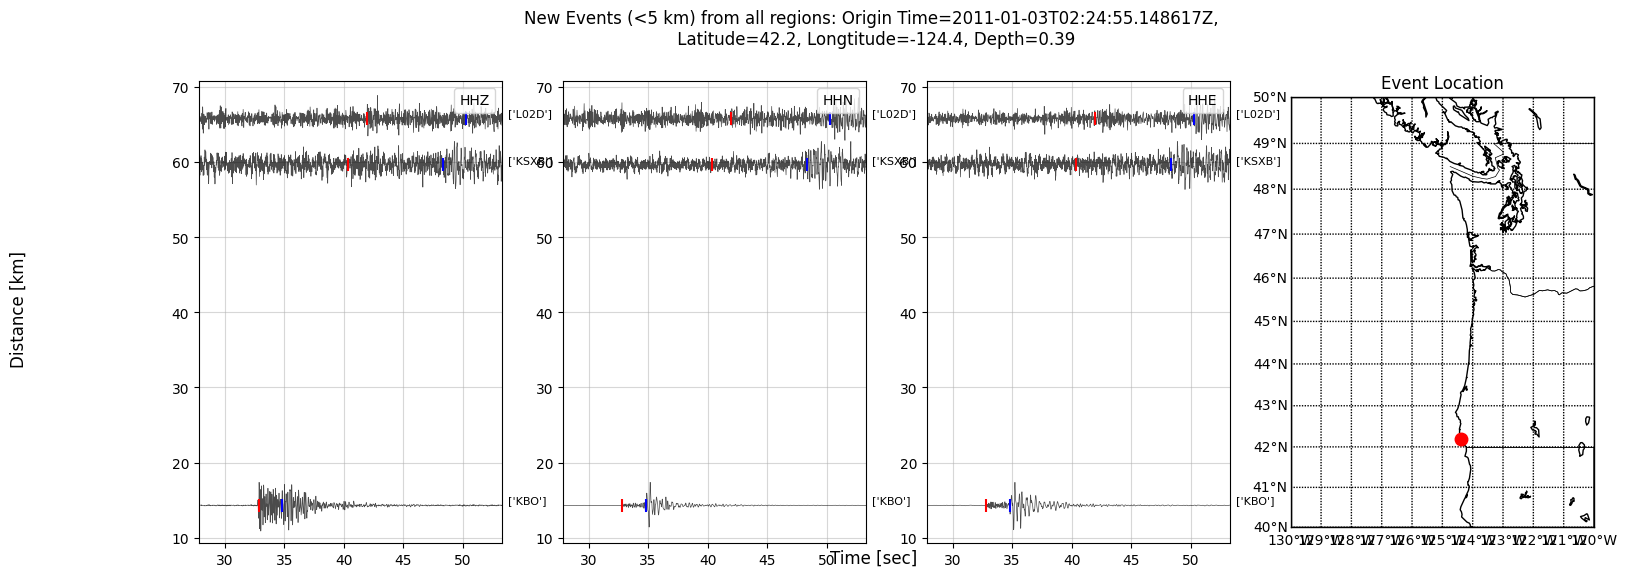

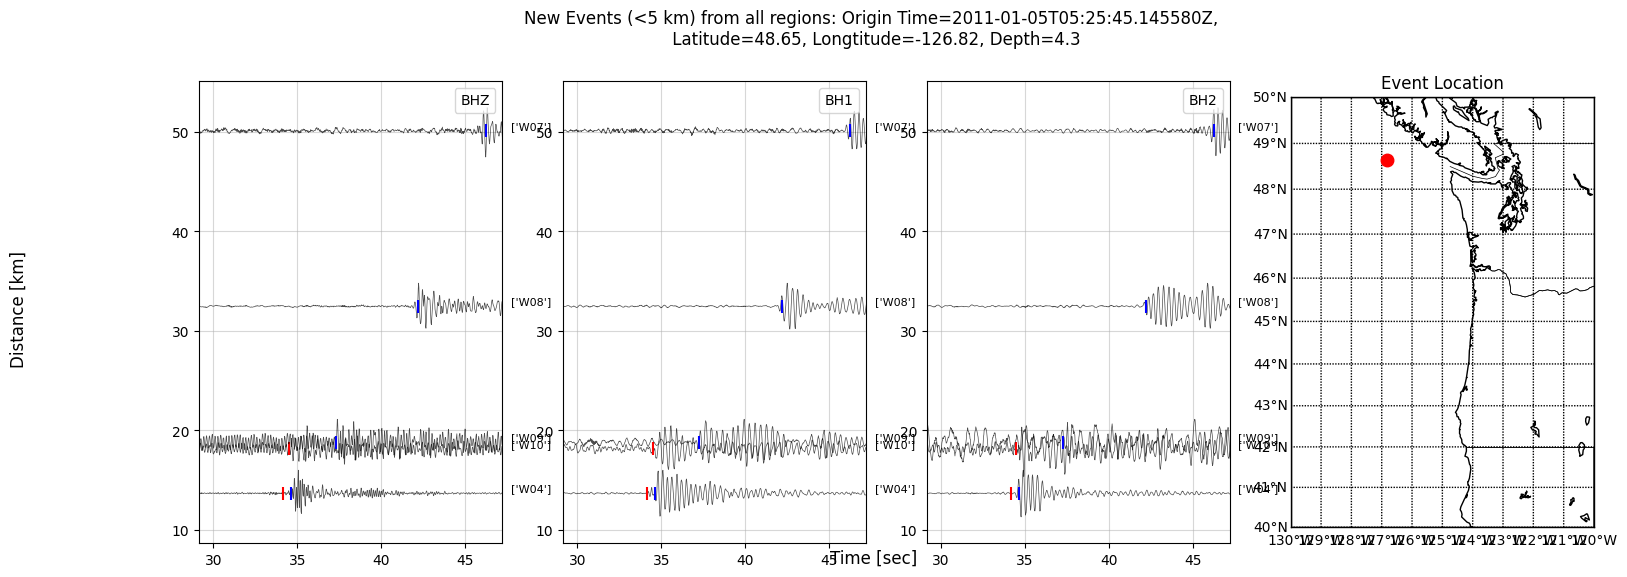

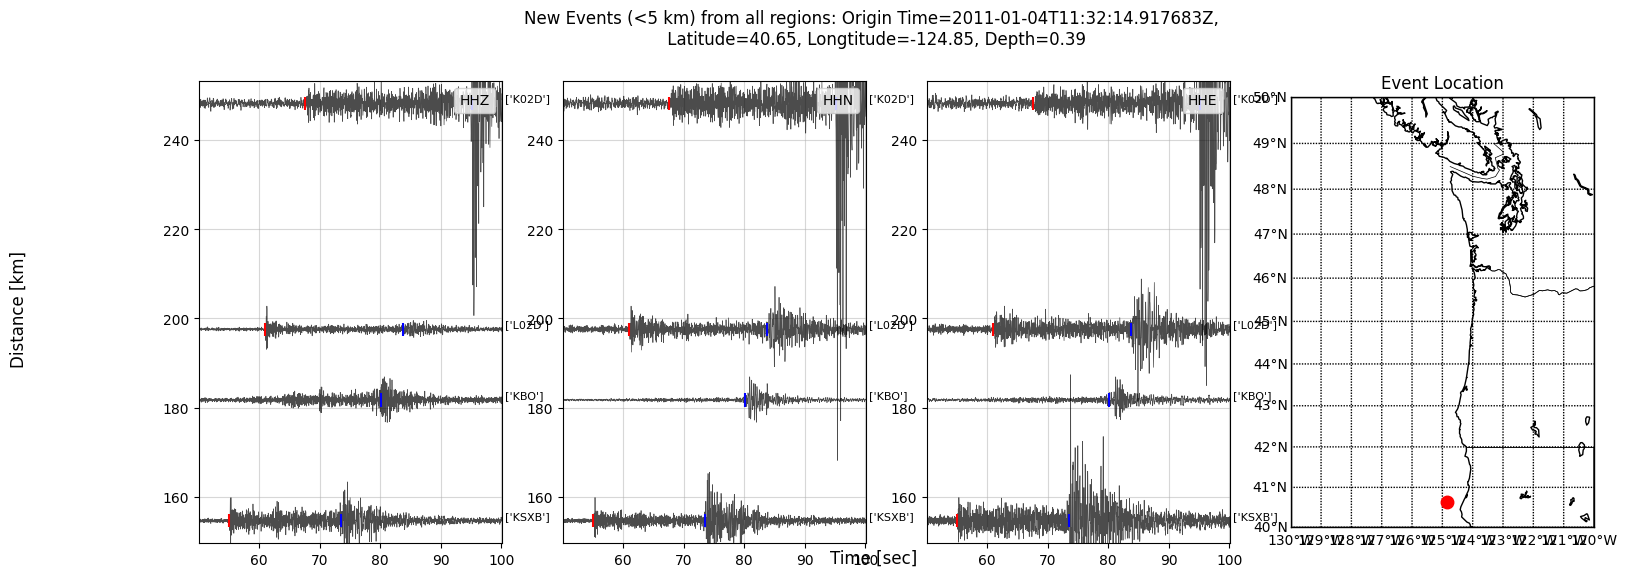

In [94]:
subplots_cluster_scale_rand(new_events, mycatalog_picks_merged, networks, channel, fig_title,filepath)

## No need to run cells below

## Plot using the plotting functions

In [ ]:
all_picks = pd.read_csv('../data/datasets_2014/all_picks_2014_for_assoc.csv')

In [ ]:
all_picks

In [ ]:
all_picks_networks = all_picks['station_network_code'].drop_duplicates()
list_networks = list(all_picks_networks)
all_picks_networks = ','.join(all_picks_networks)
all_picks_networks

In [ ]:
list_networks

In [ ]:
# Clean up the memory
del all_picks

## Plot the offshore events north of 44&deg; N

In [ ]:
new_events = pd.read_csv('../data/datasets_2014/new_events.csv')

In [ ]:
new_events_44N_and_above= new_events.loc[(new_events['latitude']>44)&(new_events['longitude']<-124)]
new_events_44N_and_above = new_events_44N_and_above[0:50] 

In [ ]:
# parameters for subplots_cluster_scale
mycatalog= mycatalog
mycatalog_picks=mycatalog_picks
networks= all_picks_networks
channel= "?H?"
idx_sta= 50
title= "Events matched"
fig_title= "new_events_filtered_44N_and_above_plots.pdf"

subplots_cluster_scale(new_events_44N_and_above,mycatalog_picks,networks,channel,idx_sta,title,fig_title)

## Plot one of the cluster events at around 46.5&deg; N, 125&deg; W using the plotting functions 

In [ ]:
def subplots_cluster_scale_p(idx, mycatalog, mycatalog_picks, networks, channel, idx_sta, title, fig_title):
    """
    idx: event_idx
    mycatalog: dataframe that contains only the unique picks (i.e., mycatalog_picks.drop_duplicates(subset=['idx']).copy())
    mycatalog_picks: all pick assignments csv file (e.g., pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv'))
    networks: string of networks (e.g., "NV,OO,7A")
    channel: specify the direction of the channel (i.e., "?HZ", "?HE" or "?HN")
    idx_sta: choose the station to which you want to show the waveforms
    title: title in a string
    fig_title: figure title in as string
    """
        
    # Define the clients 
    client_waveform = WaveformClient()
    client2 = Client("IRIS")
    client_ncedc = Client('NCEDC')


    # Plot the earthquake moveout for one of the unmatched events for all stations 
    event = mycatalog
    picks = mycatalog_picks
    picks_idx = picks.loc[picks['idx']==idx]
    pick_sta = np.unique(picks_idx['station'])
    
    otime = UTCDateTime(str(event[event['idx'] == idx]["datetime"].values[0]))
    distances = []
    max_dist = 10
    min_dist = 0
    
    print(event[event['idx'] == idx]['picks'].values[0])
    for station in pick_sta:
        
        
        sta_inv = client2.get_stations(network=networks,
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e8, endtime=otime + 1e8,level="response")
        if len(sta_inv) == 0:
#             print(f"Failed to fetch for {networks} {station} {otime}")
            continue
            
        _network = sta_inv[0].code
        slat = sta_inv[0][0].latitude
        slon = sta_inv[0][0].longitude
        olat = event.loc[event['idx']==idx, 'latitude'].values[0]
        olon = event.loc[event['idx']==idx, 'longitude'].values[0]
        
        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)
#         if max_dist < dist:
#             max_dist = dist
            
#         if min_dist > dist:
#             min_dist = dist
            
        distances.append([None, _network, station, dist])

    # Sort distances
    distances = sorted(distances, key=lambda item: item[-1])
    distances = distances[:idx_sta+1]
    
    # Set up to define the xlim and ylim
    max_y = 0
    min_y = 0
    # This count is for the if statements. Only used to ensure that min_y_count 
    #is changed from 0 to either the first positive value of the distance of one of the stations from the event
    min_y_count = 0 
    
    max_x = 0
    min_x = 0
    
    # This count is for the if statements. Only used to ensure that min_x_count 
    #is changed from 0 to either the first positive value of P pick time or the first positive value of S pick time
    min_x_count= 0
    # Create a figure
    fig,axs = plt.subplots(1,4,figsize=(18,6))
    gs = fig.add_gridspec(3, hspace=0, figure=fig)
#     axs = gs.subplots(sharex=True, sharey=True)
    starttime = otime -30
    endtime = otime + 120
    
    # Define texts
    texts = []
    
    for i, ii in enumerate(distances):
            
        if ii[1] in ['NC', 'BK']:
            # Query waveforms
            st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel,starttime=starttime, endtime=endtime)

        elif ii[1] in networks: 
            st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel,starttime=starttime, endtime=endtime)
  
        else: 
            st =  Stream()
            print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
            continue
            
#         print(f"len(st):{len(st)}")
#         print(st)
    
        # Skip empty traces
        if len(st) == 0:
                continue
                
        sta_picks = picks_idx[picks_idx['station'] == ii[2]]
        p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
        s_picks = sta_picks.loc[sta_picks['phase'] == 'S']
#         print(len(p_picks),len(s_picks))
        
        # Define the xlim values
        # Define the maximum x value
        if len(s_picks) > 0:
            if max_x < UTCDateTime(s_picks.iloc[0]['time_pick']) - starttime:
                max_x = UTCDateTime(s_picks.iloc[0]['time_pick']+5) - starttime
        elif len(p_picks) > 0:
            if max_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime: 
                max_x = UTCDateTime(p_picks.iloc[0]['time_pick']+5) - starttime
        else:
            print('No picks for this station. Skipping.')
            continue 
            
        # Define the minimum x value
        if len(p_picks) > 0:
            if min_x_count == 0:
                if min_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                    min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime
                    min_x_count += 1           
            else:
                if min_x >= UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                    min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime            
        elif len(s_picks) > 0:
            if min_x_count == 0:
                if min_x < UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                    min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5)- starttime
                    min_x_count += 1                
            else:
                if min_x >= UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                    min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5) - starttime
        else:
            print('No picks for this station. Skipping.')
            continue    
            
        if len(p_picks) == 0:
            continue
            
#         print('This is after the p_pick continue statement')
    
        # Define ylim values
        if min_y_count == 0:
            if min_y < ii[3]:
                min_y = ii[3] - 5
                min_y_count += 1           
        else:
            if min_y >= ii[3]:
                min_y = ii[3] - 5 
                
        max_y = ii[3] + 5
        
    scaling_factor = (1/2)*(max_y-min_y)   
        
    for i, ii in enumerate(distances):
            
        if ii[1] in ['NC', 'BK']:
            # Query waveforms
            st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel,starttime=starttime, endtime=endtime)

        elif ii[1] in networks: 
            st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel,starttime=starttime, endtime=endtime)
  
        else: 
            st =  Stream()
            print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
            continue
            
#         print(f"len(st):{len(st)}")
#         print(st)
    
        # Skip empty traces
        if len(st) == 0:
                continue
        _st = Stream()
        # Check for HH and BH channels presence
        has_HH = bool(st.select(channel="HH?"))
        has_BH = bool(st.select(channel="BH?"))

        # Apply selection logic based on channel presence
        if has_HH and has_BH:
            # If both HH and BH channels are present, select only HH
            _st += st.select(channel="HH?")
        elif has_HH:
            # If only HH channels are present
            _st += st.select(channel="HH?")
        elif has_BH:
            # If only BH channels are present
            _st += st.select(channel="BH?")

        st = _st

        print(f'Second st print:{_st}')
              
        st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
        st.taper(max_percentage=0.05)
        st.filter(type='bandpass', freqmin=2, freqmax=25)
        st.merge(fill_value='interpolate') # fill gaps if there are any.

#         print(st)
        # Select only one trace per channel
        unique_channels = set(tr.stats.channel for tr in st)
        selected_traces = []
        
        for ch in unique_channels:
            selected_traces.append(next(tr for tr in st if tr.stats.channel == ch))
        st = Stream(selected_traces)
                   
        trim_st = st.copy()
        sta_picks = picks_idx[picks_idx['station'] == ii[2]]
        p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
        s_picks = sta_picks.loc[sta_picks['phase'] == 'S']
#         print(len(p_picks),len(s_picks))
        
        
                
            
        if len(p_picks) == 0:
            continue 
#         print('This is after the p_pick continue statement')
        print(trim_st)
        
        for iax in range(len(trim_st)):
            print(iax)
            sampling_rate = trim_st[iax].stats.sampling_rate
            trim_st = trim_st.normalize()
            
            tp = UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30
            i1 = int((tp-5)*sampling_rate)
            i2 = int((tp+15)*sampling_rate)

            offsets1 = ii[3]
            try: 
                wave = trim_st[iax].data
                wave = wave / (np.nanmax(wave[i1:i2], axis=-1)*10)
            except:
                continue 
            
#             print(trim_st[iax].stats.sampling_rate)
            axs[iax].plot(trim_st[iax].times(), wave * scaling_factor + offsets1, 
                          color='black', label=f"{trim_st[iax].stats.channel}", alpha=0.7, lw=0.5)
#             axs[iax].plot(trim_st[iax].times(), wave * 30 + offsets1, color='black', label=f"{trim_st[iax].stats.channel}", alpha=0.7, lw=0.5)

#             axs[iax].text(xlim[-1] + 2,   offsets1, 
#                               [ii[2]], fontsize=8, verticalalignment='bottom')

            if len(p_picks) > 0:
                axs[iax].vlines(UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                offsets1 + (1/35) * scaling_factor, color='r')
            if len(s_picks) > 0:
                axs[iax].vlines(UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                offsets1 + (1/35) * scaling_factor, color='b')
        texts.append([ii[2],ii[3]])

    
#     print(max_y,min_y)
    chs = ['2','1','Z']
    for iax in range(3):
        for i, ii in enumerate(texts):
            offsets1 = ii[1]
            axs[iax].text(max_x + 0.5, offsets1, 
                                  [ii[0]], fontsize=8, verticalalignment='bottom')
        axs[iax].legend(chs[iax],loc='upper right', handlelength=0)
        axs[iax].set_ylim([min_y,max_y])
        axs[iax].set_xlim([min_x,max_x])
        axs[iax].grid(alpha=0.5)
    fig.supxlabel('Time [sec]', y=0.07)
    fig.supylabel('Distance [km]')
    fig.suptitle(f"{title}: Origin Time={otime}, \n Latitude={round(event[event['idx']==idx]['latitude'].values[0], 2)}, Longtitude={round(event[event['idx']==idx]['longitude'].values[0], 2)}, Depth={round(event[event['idx']==idx]['depth'].values[0], 2)}", y=1)
    
    m = Basemap(projection='merc', llcrnrlat=40, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-120, resolution='i', ax=axs[3])
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary()
    m.drawparallels(np.arange(40, 51, 1), labels=[1,0,0,0])
    m.drawmeridians(np.arange(-130, -119, 1), labels=[0,0,0,1])
    x, y = m(event[event['idx']==idx]['longitude'].values[0], event[event['idx']==idx]['latitude'].values[0])
    m.plot(x, y, 'ro', markersize=9)
    axs[3].set_title('Event Location')
    
    plt.show()


In [ ]:
def subplots_cluster_scale(idx, mycatalog, mycatalog_picks, networks, channel, idx_sta, title, fig_title):
    """
    idx: event_idx
    mycatalog: dataframe that contains only the unique picks (i.e., mycatalog_picks.drop_duplicates(subset=['idx']).copy())
    mycatalog_picks: all pick assignments csv file (e.g., pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv'))
    networks: string of networks (e.g., "NV,OO,7A")
    channel: specify the direction of the channel (i.e., "?HZ", "?HE" or "?HN")
    idx_sta: choose the station to which you want to show the waveforms
    title: title in a string
    fig_title: figure title in as string
    """
        
    # Define the clients 
    client_waveform = WaveformClient()
    client2 = Client("IRIS")
    client_ncedc = Client('NCEDC')


    # Plot the earthquake moveout for one of the unmatched events for all stations 
    event = mycatalog
    picks = mycatalog_picks
    
    p = PdfPages(fig_title) 
    
    for idx in event['idx']:
        
        picks_idx = picks.loc[picks['idx']==idx]
        pick_sta = np.unique(picks_idx['station'])

        otime = UTCDateTime(str(event[event['idx'] == idx]["datetime"].values[0]))
        distances = []
        max_dist = 10
        min_dist = 0

        print(event[event['idx'] == idx]['picks'].values[0])
        for station in pick_sta:


            sta_inv = client2.get_stations(network=networks,
                                           station=station, channel="?H?", 
                                           starttime=otime - 1e8, endtime=otime + 1e8,level="response")
            if len(sta_inv) == 0:
    #             print(f"Failed to fetch for {networks} {station} {otime}")
                continue

            _network = sta_inv[0].code
            slat = sta_inv[0][0].latitude
            slon = sta_inv[0][0].longitude
            olat = event.loc[event['idx']==idx, 'latitude'].values[0]
            olon = event.loc[event['idx']==idx, 'longitude'].values[0]

            dis1 = locations2degrees(olat, olon, slat, slon)
            dist = degrees2kilometers(dis1)
    #         if max_dist < dist:
    #             max_dist = dist

    #         if min_dist > dist:
    #             min_dist = dist

            distances.append([None, _network, station, dist])

        # Sort distances
        distances = sorted(distances, key=lambda item: item[-1])
        distances = distances[:idx_sta+1]

        # Set up to define the xlim and ylim
        max_y = 0
        min_y = 0
        # This count is for the if statements. Only used to ensure that min_y_count 
        #is changed from 0 to either the first positive value of the distance of one of the stations from the event
        min_y_count = 0 

        max_x = 0
        min_x = 0

        # This count is for the if statements. Only used to ensure that min_x_count 
        #is changed from 0 to either the first positive value of P pick time or the first positive value of S pick time
        min_x_count= 0
        # Create a figure
        fig,axs = plt.subplots(1,4,figsize=(18,6))
        gs = fig.add_gridspec(3, hspace=0, figure=fig)
    #     axs = gs.subplots(sharex=True, sharey=True)
        starttime = otime -30
        endtime = otime + 120

        # Define texts
        texts = []

        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                # Query waveforms
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel,starttime=starttime, endtime=endtime)

            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel,starttime=starttime, endtime=endtime)

            else: 
                st =  Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

    #         print(f"len(st):{len(st)}")
    #         print(st)

            # Skip empty traces
            if len(st) == 0:
                    continue

            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']
    #         print(len(p_picks),len(s_picks))

            # Define the xlim values
            # Define the maximum x value
            if len(s_picks) > 0:
                if max_x < UTCDateTime(s_picks.iloc[0]['time_pick']) - starttime:
                    max_x = UTCDateTime(s_picks.iloc[0]['time_pick']+5) - starttime
            elif len(p_picks) > 0:
                if max_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime: 
                    max_x = UTCDateTime(p_picks.iloc[0]['time_pick']+5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue 

            # Define the minimum x value
            if len(p_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime
                        min_x_count += 1           
                else:
                    if min_x >= UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime            
            elif len(s_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5)- starttime
                        min_x_count += 1                
                else:
                    if min_x >= UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue    

    #         if len(p_picks) == 0:
    #             continue

    #         print('This is after the p_pick continue statement')

            # Define ylim values
            if min_y_count == 0:
                if min_y < ii[3]:
                    min_y = ii[3] - 5
                    min_y_count += 1           
            else:
                if min_y >= ii[3]:
                    min_y = ii[3] - 5 

            max_y = ii[3] + 5

        scaling_factor = (1/2)*(max_y-min_y)   

        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                # Query waveforms
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel,starttime=starttime, endtime=endtime)

            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel,starttime=starttime, endtime=endtime)

            else: 
                st =  Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

    #         print(f"len(st):{len(st)}")
    #         print(st)

            # Skip empty traces
            if len(st) == 0:
                    continue
            _st = Stream()
            # Check for HH and BH channels presence
            has_HH = bool(st.select(channel="HH?"))
            has_BH = bool(st.select(channel="BH?"))

            # Apply selection logic based on channel presence
            if has_HH and has_BH:
                # If both HH and BH channels are present, select only HH
                _st += st.select(channel="HH?")
            elif has_HH:
                # If only HH channels are present
                _st += st.select(channel="HH?")
            elif has_BH:
                # If only BH channels are present
                _st += st.select(channel="BH?")

            st = _st

            print(f'Second st print:{_st}')

            st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
            st.taper(max_percentage=0.05)
            st.filter(type='bandpass', freqmin=2, freqmax=25)
            st.merge(fill_value='interpolate') # fill gaps if there are any.

    #         print(st)
            # Select only one trace per channel
            unique_channels = set(tr.stats.channel for tr in st)
            selected_traces = []

            for ch in unique_channels:
                selected_traces.append(next(tr for tr in st if tr.stats.channel == ch))
            st = Stream(selected_traces)

            trim_st = st.copy()
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']
    #         print(len(p_picks),len(s_picks))




    #         if len(p_picks) == 0:
    #             continue 
    #         print('This is after the p_pick continue statement')
            print(trim_st)

            for iax in range(len(trim_st)):
                print(iax)
                sampling_rate = trim_st[iax].stats.sampling_rate
                trim_st = trim_st.normalize()

                if len(p_picks)>0:
                    tp = UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((tp-5)*sampling_rate)
                    i2 = int((tp+15)*sampling_rate)
                elif len(s_picks)>0:
                    ts = UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((ts-10)*sampling_rate)
                    i2 = int((ts+10)*sampling_rate)
                else:
                    print(f"WARNING: No pick time for {ii[1]}.{ii[2]}.{channel} on {otime}.")

                offsets1 = ii[3]
                try: 
                    wave = trim_st[iax].data
                    wave = wave / (np.nanmax(wave[i1:i2], axis=-1)*10)
                except:
                    continue 

    #             print(trim_st[iax].stats.sampling_rate)
                axs[iax].plot(trim_st[iax].times(), wave * scaling_factor + offsets1, 
                              color='black', label=f"{trim_st[iax].stats.channel}", alpha=0.7, lw=0.5)
    #             axs[iax].plot(trim_st[iax].times(), wave * 30 + offsets1, color='black', label=f"{trim_st[iax].stats.channel}", alpha=0.7, lw=0.5)

    #             axs[iax].text(xlim[-1] + 2,   offsets1, 
    #                               [ii[2]], fontsize=8, verticalalignment='bottom')

                if len(p_picks) > 0:
                    axs[iax].vlines(UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='r')
                if len(s_picks) > 0:
                    axs[iax].vlines(UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='b')
            texts.append([ii[2],ii[3]])


    #     print(max_y,min_y)
        chs = ['2','1','Z']
        for iax in range(3):
            for i, ii in enumerate(texts):
                offsets1 = ii[1]
                axs[iax].text(max_x + 0.5, offsets1, 
                                      [ii[0]], fontsize=8, verticalalignment='bottom')
            axs[iax].legend(chs[iax],loc='upper right', handlelength=0)
            axs[iax].set_ylim([min_y,max_y])
            axs[iax].set_xlim([min_x,max_x])
            axs[iax].grid(alpha=0.5)
        fig.supxlabel('Time [sec]', y=0.07)
        fig.supylabel('Distance [km]')
        fig.suptitle(f"{title}: Origin Time={otime}, \n Latitude={round(event[event['idx']==idx]['latitude'].values[0], 2)}, Longtitude={round(event[event['idx']==idx]['longitude'].values[0], 2)}, Depth={round(event[event['idx']==idx]['depth'].values[0], 2)}", y=1)

        m = Basemap(projection='merc', llcrnrlat=40, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-120, resolution='i', ax=axs[3])
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()
        m.drawmapboundary()
        m.drawparallels(np.arange(40, 51, 1), labels=[1,0,0,0])
        m.drawmeridians(np.arange(-130, -119, 1), labels=[0,0,0,1])
        x, y = m(event[event['idx']==idx]['longitude'].values[0], event[event['idx']==idx]['latitude'].values[0])
        m.plot(x, y, 'ro', markersize=9)
        axs[3].set_title('Event Location')
        
        fig.savefig(p, format='pdf')  

    p.close()

### Specify the latitudes and longitudes

In [ ]:
new_events = pd.read_csv('../data/datasets_2014/new_events.csv')

In [ ]:
idx = new_events[new_events['station']=='J25B']['idx'].values
idx

In [ ]:
new_events = new_events[new_events["idx"].isin(idx)]
new_events

In [ ]:
new_events_specific_lat_lon = new_events.loc[(new_events['latitude']>46)&(new_events['latitude']<47.5)&(new_events['longitude']<-124)&(new_events['longitude']>-126)]
new_events_specific_lat_lon

In [ ]:
# new_events = new_events_specific_lat_lon.loc[(new_events_specific_lat_lon['depth']>1)&(new_events_specific_lat_lon['depth']<40)]
new_events = new_events_specific_lat_lon.loc[new_events_specific_lat_lon['picks']>=6][0:30]
new_events

### Histogram: Depths of events

In [ ]:
# Plot the histogram of the number of picks for the matched events
plt.figure()
bins = np.linspace(0,50,25)
plt.hist(new_events['depth'],bins=bins)
plt.xlabel('Depth (km)')
plt.ylabel('Number of Events')
plt.title('Histogram of the depths of the events in the cluster at ~46.5$^\circ$ N')

### Plot HH?

In [ ]:
# parameters
mycatalog= mycatalog
mycatalog_picks=mycatalog_picks
networks= all_picks_networks
channel= "HH?"
idx_sta= 50
title= "Events matched"
fig_title= "events_matched.png"
ylim= [0,300]
xlim= [30,45]

for idx in new_events['idx']:
    subplots_cluster_scale_p(idx,mycatalog,mycatalog_picks,networks,channel,idx_sta,title,fig_title,ylim,xlim)

### Plot BH?

In [ ]:
# parameters
mycatalog= mycatalog
mycatalog_picks=mycatalog_picks
networks= all_picks_networks
channel= "BH?"
idx_sta= 50
title= "Events matched"
fig_title= "events_matched.png"
ylim= [0,300]
xlim= [30,45]

for idx in new_events['idx']:
    subplots_cluster_scale_p(idx,mycatalog,mycatalog_picks,networks,channel,idx_sta,title,fig_title,ylim,xlim)

### Plot both HH? and BH?

In [ ]:
new_events['datetime'] = pd.to_datetime(new_events['datetime'], utc = True)
new_events

In [ ]:
# parameters for subplots_cluster_scale_p
mycatalog= mycatalog
mycatalog_picks=mycatalog_picks
networks= all_picks_networks
channel= "?H?"
idx_sta= 50
title= "Events matched"
fig_title= "events_matched.png"

for idx in new_events['idx']:
    subplots_cluster_scale_p(idx,new_events,mycatalog_picks,networks,channel,idx_sta,title,fig_title)

In [ ]:
# parameters for subplots_cluster_scale
mycatalog= mycatalog
mycatalog_picks=mycatalog_picks
networks= all_picks_networks
channel= "?H?"
idx_sta= 50
title= "Events matched"
fig_title= "new_events_plots.pdf"

subplots_cluster_scale(new_events,mycatalog_picks,networks,channel,idx_sta,title,fig_title)

In [ ]:
# Plot the histogram of the number of picks for the matched events
new_events['time'] = pd.to_datetime(new_events['time'])
year1 = 2012
time1 = datetime(year=year1, month=1, day=1)
time2 = datetime(year=year1 + 1, month=1, day=1)
time_bins = pd.date_range(start=time1, end=time2, freq='5D')
plt.figure()
plt.hist(new_events['time'], bins=time_bins)
plt.xlabel('Days')
plt.ylabel('Number of Events')
plt.title('Histogram for the frequency of the events in the cluster at ~46.5$^\circ$ N')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.show()

In [ ]:
import matplotlib 
from matplotlib import pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages 

# customizing runtime configuration stored 
# in matplotlib.rcParams 
plt.rcParams["figure.figsize"] = [7.00, 3.50] 
plt.rcParams["figure.autolayout"] = True

fig1 = plt.figure() 
plt.plot([17, 45, 7, 8, 7], color='orange') 

fig2 = plt.figure() 
plt.plot([13, 25, 1, 6, 3], color='blue') 

Fig3 = plt.figure() 
plt.plot([22, 11, 2, 1, 23], color='green') 


def save_image(filename): 
	
	# PdfPages is a wrapper around pdf 
	# file so there is no clash and create 
	# files with no error. 
	p = PdfPages(filename) 
	
	# get_fignums Return list of existing 
	# figure numbers 
	fig_nums = plt.get_fignums() 
	figs = [plt.figure(n) for n in fig_nums] 
	
	# iterating over the numbers in list 
	for fig in figs: 
		
		# and saving the files 
		fig.savefig(p, format='pdf') 
	
	# close the object 
	p.close() 

# name your Pdf file 
filename = "multi_plot_image.pdf"

# call the function 
save_image(filename) 


## Plot the cluster events at around 43.25&deg; N, 124.25&deg; W using the plotting functions 

In [ ]:
new_events_specific_lat_lon = unmatched_events_mycatalog2morton_and_anss.loc[(unmatched_events_mycatalog2morton_and_anss['latitude']>43.0)&(unmatched_events_mycatalog2morton_and_anss['latitude']<43.3)&(unmatched_events_mycatalog2morton_and_anss['longitude']<-124.25)&(unmatched_events_mycatalog2morton_and_anss['longitude']>-124.75)]
new_events_specific_lat_lon

In [ ]:
new_events = new_events_specific_lat_lon.loc[new_events_specific_lat_lon['picks']>5]
new_events

### Plot HH?

In [ ]:
# parameters
mycatalog= mycatalog
mycatalog_picks=mycatalog_picks
networks= all_picks_networks
channel= "HH?"
idx_sta= 50
title= "Events matched"
fig_title= "events_matched.png"
ylim= [0,300]
xlim= [20,150]

for idx in new_events['idx']:
    subplots_cluster_scale_p(idx,mycatalog,mycatalog_picks,networks,channel,idx_sta,title,fig_title,ylim,xlim)

### Plot BH?

In [ ]:
# parameters
mycatalog= mycatalog
mycatalog_picks=mycatalog_picks
networks= all_picks_networks
channel= "BH?"
idx_sta= 50
title= "Events matched"
fig_title= "events_matched.png"
ylim= [0,300]
xlim= [20,150]

for idx in new_events['idx']:
    subplots_cluster_scale_p(idx,mycatalog,mycatalog_picks,networks,channel,idx_sta,title,fig_title,ylim,xlim)

## Calculate SNRs

In [ ]:
all_picks = pd.read_csv('../data/datasets_2014/all_picks_2014.csv')
all_pick_assignments = pd.read_csv('../data/datasets_2014/all_pick_assignments_2014.csv')

In [ ]:
def calc_snr(all_picks,all_pick_assignments):
    """ 
    This function calculates the SNRs for each station in each event.
    
    Inputs:
    1. The all_pick.csv file from the 2_format_pick2associate file.
    2. The all_pick_assignments.csv file from the 3_association file.
    
    Oututs:
    The new all_pick_assignments_snr file with the additional SNR column.
    """
    
    # Create the list of networks
    all_picks_networks = all_picks['station_network_code'].drop_duplicates()
    list_networks = list(all_picks_networks)
    networks = ','.join(all_picks_networks)
    
    
    
    # Define the clients 
    client_waveform = WaveformClient()
    client2 = Client("IRIS")
    client_ncedc = Client('NCEDC')
    
    all_pick_assignments['datetime'] = pd.to_datetime(all_pick_assignments['time'], utc = True)

    
    # Define parameters
    percentile=98
    
    # Create empty lists
    snr_list = []
        
    # Make sure if a station for an event has more than 1 P or S pick
    for idx in all_pick_assignments['idx'].drop_duplicates():
        # Define parameters
        otime = UTCDateTime(str(all_pick_assignments[all_pick_assignments['idx'] == idx]["datetime"].values[0]))


        # Create empty lists
        networks_stas = []

        # Plot the earthquake moveout for one of the unmatched events for all stations 
    #     event = mycatalog
        pick_idx = all_pick_assignments.loc[all_pick_assignments['idx']==idx]
        pick_sta = np.unique(pick_idx['station'])
        
    #     distances = []
    #     max_dist = 10
    #     min_dist = 0
        for station in pick_sta:

            sta_inv = client2.get_stations(network=networks,
                                           station=station, channel="?H?", 
                                           starttime=otime - 1e8, endtime=otime + 1e8,level="response")
            if len(sta_inv) == 0:
                print(f'No inventory for station {station}. Skipping.')
                continue

            network = sta_inv[0].code
    #         slat = sta_inv[0][0].latitude
    #         slon = sta_inv[0][0].longitude
    #         olat = event.loc[event['idx']==idx, 'latitude'].values[0]
    #         olon = event.loc[event['idx']==idx, 'longitude'].values[0]

    #         dis1 = locations2degrees(olat, olon, slat, slon)
    #         dist = degrees2kilometers(dis1)
    # #         if max_dist < dist:
    # #             max_dist = dist

    # #         if min_dist > dist:
    # #             min_dist = dist

            networks_stas.append([network,station])
        
   
        events = all_pick_assignments[all_pick_assignments['idx']==idx]
        for i in networks_stas:
            events1 = events[events['station']==i[1]]
            p_picks = events1[events1['phase']=='P']
            s_picks = events1[events1['phase']=='S']
            

            if len(p_picks)>0 and len(s_picks)>0:
                print(p_picks['datetime'].values,s_picks['datetime'].values)
                p_pick_time = UTCDateTime(str(p_picks['datetime'].values[0]))
                s_pick_time = UTCDateTime(str(s_picks['datetime'].values[0]))
                
                starttime_st = UTCDateTime(p_pick_time)-timedelta(seconds=120)
                endtime_st = UTCDateTime(p_pick_time)+timedelta(seconds=120)
                
                starttime_noise = UTCDateTime(p_pick_time)-timedelta(seconds=8)
                endtime_noise = UTCDateTime(p_pick_time)
                
                starttime_signal = UTCDateTime(s_pick_time)-timedelta(seconds=1)
                endtime_signal = UTCDateTime(s_pick_time)+timedelta(seconds=2)
                
                print(starttime_noise,endtime_noise)
            
                if i[0] in ['NC', 'BK']:
                # Query waveforms
                    st = client_ncedc.get_waveforms(network=i[0], station=i[1],
                                                    location="*", channel="?HZ",starttime=starttime_st,
                                                    endtime=endtime_st)

                elif i[0] in networks: 
                    st = client_waveform.get_waveforms(network=i[0], station=i[1],
                                                       channel='?HZ',starttime=starttime_st, endtime=endtime_st)

                else: 
                    st =  Stream()
                    print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                    continue

        #         print(f"len(st):{len(st)}")
        #         print(st)

                # Skip empty traces
                if len(st) == 0:
                    continue
                    
                print(f'First st print:{st}')
                # Create a new stream
                _st = Stream()
                # Check for HH and BH channels presence
                has_HH = bool(st.select(channel="HH?"))
                has_BH = bool(st.select(channel="BH?"))

                # Apply selection logic based on channel presence
                if has_HH and has_BH:
                    # If both HH and BH channels are present, select only HH
                    _st += st.select(channel="HH?")
                elif has_HH:
                    # If only HH channels are present
                    _st += st.select(channel="HH?")
                elif has_BH:
                    # If only BH channels are present
                    _st += st.select(channel="BH?")

                _st.merge(fill_value='interpolate') # fill gaps if there are any.

                print(f'Second st print:{_st}')
            
                noise = _st.copy().trim(starttime=starttime_noise,endtime=endtime_noise)    
                signal = _st.copy().trim(starttime=starttime_signal,endtime=endtime_signal) 
                
                print(f"P and S pick times:{p_pick_time} and {s_pick_time}")
                print(f"Stream start and end times:{starttime_st} and {endtime_st}")
                print(f"Noise start and end times:{starttime_noise} and {endtime_noise}")
                print(f"Signal start and end times:{starttime_signal} and {endtime_signal}")
                
                print(f'Noise:{noise}')
                print(f'Signal:{signal}')

                noise_abs = np.percentile(abs(noise[0].data),percentile)
                signal_abs = np.percentile(abs(signal[0].data),percentile)

                snr = 20 * np.log10((signal_abs/noise_abs))

                snr_list.append(snr)
                
            if len(p_picks)>0 and len(s_picks)==0:
                
                print(p_picks['datetime'].values,s_picks['datetime'].values)
                p_pick_time = UTCDateTime(str(p_picks['datetime'].values[0]))
#                 s_pick_time = UTCDateTime(str(s_picks['datetime'].values[0]))

                starttime_st = UTCDateTime(p_pick_time)-timedelta(seconds=120)
                endtime_st = UTCDateTime(p_pick_time)+timedelta(seconds=120)
                
                starttime_noise = UTCDateTime(p_pick_time)-timedelta(seconds=8)
                endtime_noise = UTCDateTime(p_pick_time)
                
                starttime_signal = UTCDateTime(p_pick_time)+timedelta(seconds=1)
                endtime_signal = UTCDateTime(p_pick_time)+timedelta(seconds=4)
                
            
                if i[0] in ['NC', 'BK']:
                # Query waveforms
                    st = client_ncedc.get_waveforms(network=i[0], station=i[1],
                                                    location="*", channel="?HZ",starttime=starttime_st, 
                                                    endtime=endtime_st)

                elif i[0] in networks: 
                    st = client_waveform.get_waveforms(network=i[0], station=i[1],
                                                       channel='?HZ',starttime=starttime_st, endtime=endtime_st)

                else: 
                    st =  Stream()
                    print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                    continue

        #         print(f"len(st):{len(st)}")
        #         print(st)

                # Skip empty traces
                if len(st) == 0:
                    continue
                print(f'First st print:{st}')
                # Create a new stream
                _st = Stream()
                # Check for HH and BH channels presence
                has_HH = bool(st.select(channel="HH?"))
                has_BH = bool(st.select(channel="BH?"))

                # Apply selection logic based on channel presence
                if has_HH and has_BH:
                    # If both HH and BH channels are present, select only HH
                    _st += st.select(channel="HH?")
                elif has_HH:
                    # If only HH channels are present
                    _st += st.select(channel="HH?")
                elif has_BH:
                    # If only BH channels are present
                    _st += st.select(channel="BH?")

                _st.merge(fill_value='interpolate') # fill gaps if there are any.

                print(f'Second st print:{_st}')
                
                
                    

                noise = _st.copy().trim(starttime=starttime_noise,endtime=endtime_noise)    
                signal = _st.copy().trim(starttime=starttime_signal,endtime=endtime_signal) 
                
                print(f"P pick time:{p_pick_time}")
                print(f"Stream start and end times:{starttime_st} and {endtime_st}")
                print(f"Noise start and end times:{starttime_noise} and {endtime_noise}")
                print(f"Signal start and end times:{starttime_signal} and {endtime_signal}")

                print(f'Noise:{noise}')
                print(f'Signal:{signal}')

                noise_abs = np.percentile(abs(noise[0].data),percentile)
                signal_abs = np.percentile(abs(signal[0].data),percentile)

                snr = 20 * np.log10((signal_abs/noise_abs))

                snr_list.append(snr)
                    
            if len(p_picks)==0 and len(s_picks)>0:
                print(p_picks['datetime'].values,s_picks['datetime'].values)
#                 p_pick_time = UTCDateTime(str(p_picks['datetime'].values))
                s_pick_time = UTCDateTime(str(s_picks['datetime'].values[0]))
    
                starttime_st = UTCDateTime(s_pick_time)-timedelta(seconds=120)
                endtime_st = UTCDateTime(s_pick_time)+timedelta(seconds=120)
                
                starttime_noise = UTCDateTime(s_pick_time)-timedelta(seconds=8)
                endtime_noise = UTCDateTime(s_pick_time)
                
                starttime_signal = UTCDateTime(s_pick_time)
                endtime_signal = UTCDateTime(s_pick_time)+timedelta(seconds=3)
                
                print(starttime_noise,endtime_noise)
            
                if i[0] in ['NC', 'BK']:
                # Query waveforms
                    st = client_ncedc.get_waveforms(network=i[0], station=i[1],
                                                    location="*", channel="?HZ",starttime=starttime_st, 
                                                    endtime=endtime_st)

                elif i[0] in networks: 
                    st = client_waveform.get_waveforms(network=i[0], station=i[1],
                                                       channel='?HZ',starttime=starttime_st, endtime=endtime_st)

                else: 
                    st =  Stream()
                    print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                    continue

        #         print(f"len(st):{len(st)}")
        #         print(st)

                # Skip empty traces
                if len(st) == 0:
                    continue
                    
                print(f'First st print:{st}')
                # Create a new stream
                _st = Stream()
                # Check for HH and BH channels presence
                has_HH = bool(st.select(channel="HH?"))
                has_BH = bool(st.select(channel="BH?"))

                # Apply selection logic based on channel presence
                if has_HH and has_BH:
                    # If both HH and BH channels are present, select only HH
                    _st += st.select(channel="HH?")
                elif has_HH:
                    # If only HH channels are present
                    _st += st.select(channel="HH?")
                elif has_BH:
                    # If only BH channels are present
                    _st += st.select(channel="BH?")

                _st.merge(fill_value='interpolate') # fill gaps if there are any.

                print(f'Second st print:{_st}')

            
                noise = _st.copy().trim(starttime=starttime_noise,endtime=endtime_noise)    
                signal = _st.copy().trim(starttime=starttime_signal,endtime=endtime_signal) 
                
                print(f"S pick time:{s_pick_time}")
                print(f"Stream start and end times:{starttime_st} and {endtime_st}")
                print(f"Noise start and end times:{starttime_noise} and {endtime_noise}")
                print(f"Signal start and end times:{starttime_signal} and {endtime_signal}")
                
                print(f'Noise:{noise}')
                print(f'Signal:{signal}')

                noise_abs = np.percentile(abs(noise[0].data),percentile)
                signal_abs = np.percentile(abs(signal[0].data),percentile)

                snr = 20 * np.log10((signal_abs/noise_abs))

                snr_list.append(snr)
            
    all_assignments_picks['snr']=snr_list
     
    return snr_list

In [ ]:
snr_list = calc_snr(all_picks,all_pick_assignments)

In [ ]:
snr_list

In [ ]:
client_waveform = WaveformClient()

p_pick_time = '2014-01-02T07:40:02.642533Z'

starttime_st = UTCDateTime(p_pick_time)-timedelta(seconds=120)
endtime_st = UTCDateTime(p_pick_time)+timedelta(seconds=120)

# starttime_st = UTCDateTime('2011-01-03T00:00:0.000000Z')
# endtime_st = UTCDateTime('2011-01-03T12:59:59.000000Z')

print(f'Requested start and end times:{starttime_st} and {endtime_st}')


st = client_waveform.get_waveforms(network='CN', station='BTB',
                                       channel='HHZ',starttime=starttime_st, endtime=endtime_st)
print(f'Actual start and end times: {st[0].stats.starttime} and {st[0].stats.endtime}')
